Model 3:
The analysis in this notebook focuses on both labelled and unlabelled data including current ongoing records of accepted and rejected lending club dataset. Labels for unlabelled is predicted using Label propagation methods, Label propagation and Label spreading. This creates credit scoring model using SVM and random forest, logistic regression classification considering rejected applications along with class balancing methods. 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from matplotlib import pyplot as plt
from IPython.display import display
from dateutil import parser
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import roc_auc_score


# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

<h3>Loading the dataset </h3>

In [ ]:
# Import the reject dataset
path='/content/drive/My Drive/Colab Notebooks/LJMU Thesis/LC_rejected_2017.csv'
#path='/content/drive/My Drive/Colab Notebooks/LJMU Thesis/LC_dataset_accepted_2016_17.csv'
loan_df = pd.read_csv(path)

In [ ]:
# making a copy to avoid re - reading the whole data set.
df = loan_df.copy(deep=True)
df.head(20)

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,20000.0,2017-01-01,debt_consolidation,NaN,0%,316xx,GA,NaN,0.0
1,15000.0,2017-01-01,home_improvement,NaN,0.58%,190xx,PA,< 1 year,0.0
2,1000.0,2017-01-01,Debt consolidation,528.0,0%,775xx,TX,< 1 year,0.0
3,2500.0,2017-01-01,car,NaN,1.7%,199xx,DE,5 years,0.0
4,6000.0,2017-01-01,credit_card,NaN,2.93%,761xx,TX,5 years,0.0
5,10000.0,2017-01-01,debt_consolidation,NaN,-1%,358xx,AL,< 1 year,0.0
6,15000.0,2017-01-01,debt_consolidation,NaN,1.74%,190xx,PA,< 1 year,0.0
7,5000.0,2017-01-01,debt_consolidation,NaN,257.83%,462xx,IN,< 1 year,0.0
8,1000.0,2017-01-01,other,NaN,44.36%,302xx,GA,5 years,0.0
9,30000.0,2017-01-01,home_improvement,NaN,2.85%,293xx,SC,< 1 year,0.0


<h3>Understanding the dataset</h3>

In [ ]:
df.shape

(7072573, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7072573 entries, 0 to 7072572
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 485.6+ MB


<h3> Check Missing Values </h3>

In [ ]:
# Checking for missing values
total_miss_data= df.isnull().sum().sort_values(ascending=False)
percent_miss_data= (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
Risk_Score,3246249,45.899123
Employment Length,304529,4.305774
Loan Title,1098,0.015525
Policy Code,918,0.012980
Zip Code,2,0.000028
State,0,0.000000
Debt-To-Income Ratio,0,0.000000
Application Date,0,0.000000
Amount Requested,0,0.000000


In [ ]:
# Removing zip code and state as it is not required for this analysis
df.drop(["Zip Code", "State"], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7072573 entries, 0 to 7072572
Data columns (total 7 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Employment Length     object 
 6   Policy Code           float64
dtypes: float64(3), object(4)
memory usage: 377.7+ MB


In [ ]:
df['Policy Code'].value_counts(dropna=False)

0.0    7053928
2.0      17727
NaN        918
Name: Policy Code, dtype: int64

In [ ]:
# Most of the records belong to policy code - 0.0 - publicly available. There are some records that are not available for public which are thus rejected. The variance is nearly zero.
# Removing policy code column
df.drop(["Policy Code"], axis=1, inplace=True)

In [ ]:
df.rename(columns={"Amount Requested": "loan_amnt", "Loan Title": "title", "Employment Length": "emp_length", "Debt-To-Income Ratio": "dti","Risk_Score": "fico_score","Application Date": "issue_d" }, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7072573 entries, 0 to 7072572
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   loan_amnt   float64
 1   issue_d     object 
 2   title       object 
 3   fico_score  float64
 4   dti         object 
 5   emp_length  object 
dtypes: float64(2), object(4)
memory usage: 323.8+ MB


In [ ]:
# issued date or application date is not useful for our analysis
df.drop(["issue_d"], axis=1, inplace=True)

In [ ]:
# check missing values again
# Checking for missing values
total_miss_data= df.isnull().sum().sort_values(ascending=False)
percent_miss_data= (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
fico_score,3246249,45.899123
emp_length,304529,4.305774
title,1098,0.015525
dti,0,0.000000
loan_amnt,0,0.000000


In [ ]:
df['title'].value_counts(dropna=False)

Debt consolidation         1894884
debt_consolidation         1367023
Other                       650929
other                       606027
Credit card refinancing     550381
credit_card                 258356
Car financing               253706
home_improvement            176981
Home improvement            172315
Medical expenses            130575
car                         122953
major_purchase              119102
Major purchase              104021
Moving and relocation        99026
Home buying                  96261
Business                     73829
moving                       72578
Business Loan                70517
medical                      67713
small_business               47408
Vacation                     45131
vacation                     40111
house                        34866
Green loan                   11579
renewable_energy              5162
NaN                           1098
Learning and training           41
Name: title, dtype: int64

In [ ]:
df.loc[(df['title'] == "debt_consolidation"), 'title'] = 'Debt consolidation'


In [ ]:
df['title'].value_counts(dropna=False)

Debt consolidation         3261907
Other                       650929
other                       606027
Credit card refinancing     550381
credit_card                 258356
Car financing               253706
home_improvement            176981
Home improvement            172315
Medical expenses            130575
car                         122953
major_purchase              119102
Major purchase              104021
Moving and relocation        99026
Home buying                  96261
Business                     73829
moving                       72578
Business Loan                70517
medical                      67713
small_business               47408
Vacation                     45131
vacation                     40111
house                        34866
Green loan                   11579
renewable_energy              5162
NaN                           1098
Learning and training           41
Name: title, dtype: int64

In [ ]:
df.loc[(df['title'] == "other"), 'title'] = 'Other'
df.loc[(df['title'] == "credit_card"), 'title'] = 'Credit card refinancing'
df.loc[(df['title'] == "car"), 'title'] = 'Car financing'
df.loc[(df['title'] == "home_improvement"), 'title'] = 'Home improvement'
df.loc[(df['title'] == "major_purchase"), 'title'] = 'Major purchase'
df.loc[(df['title'] == "vacation"), 'title'] = 'Vacation'
df.loc[(df['title'] == "moving"), 'title'] = 'Moving and relocation'
df.loc[(df['title'] == "Business"), 'title'] = 'Business Loan'
df.loc[(df['title'] == "renewable_energy"), 'title'] = 'Green loan'
df.loc[(df['title'] == "medical"), 'title'] = 'Medical expenses'

In [ ]:
df['title'].value_counts(dropna=False)

Debt consolidation         3261907
Other                      1256956
Credit card refinancing     808737
Car financing               376659
Home improvement            349296
Major purchase              223123
Medical expenses            198288
Moving and relocation       171604
Business Loan               144346
Home buying                  96261
Vacation                     85242
small_business               47408
house                        34866
Green loan                   16741
NaN                           1098
Learning and training           41
Name: title, dtype: int64

In [ ]:
df.loc[(df['title'] == "Home buying"), 'title'] = 'house'
df.loc[(df['title'] == "small_business"), 'title'] = 'Business Loan'

In [ ]:
df['title'].value_counts(dropna=False)

Debt consolidation         3261907
Other                      1256956
Credit card refinancing     808737
Car financing               376659
Home improvement            349296
Major purchase              223123
Medical expenses            198288
Business Loan               191754
Moving and relocation       171604
house                       131127
Vacation                     85242
Green loan                   16741
NaN                           1098
Learning and training           41
Name: title, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7072573 entries, 0 to 7072572
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   loan_amnt   float64
 1   title       object 
 2   fico_score  float64
 3   dti         object 
 4   emp_length  object 
dtypes: float64(2), object(3)
memory usage: 269.8+ MB


In [ ]:
# removing null records for column title
df=df[df['title'].notna()]

In [ ]:
df['title'].value_counts(dropna=False)

Debt consolidation         3261907
Other                      1256956
Credit card refinancing     808737
Car financing               376659
Home improvement            349296
Major purchase              223123
Medical expenses            198288
Business Loan               191754
Moving and relocation       171604
house                       131127
Vacation                     85242
Green loan                   16741
Learning and training           41
Name: title, dtype: int64

In [ ]:
df['emp_length'].value_counts(dropna=False)

< 1 year     5522024
5 years       944365
NaN           304529
10+ years      76356
1 year         75450
2 years        47798
3 years        36469
4 years        26291
6 years        12830
7 years         9643
8 years         8474
9 years         7246
Name: emp_length, dtype: int64

In [ ]:
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace(to_replace='< 1 year', value='0 year', inplace=True)
df['emp_length'].value_counts(dropna=False)


0 year      5522024
5 years      944365
NaN          304529
10 years      76356
1 year        75450
2 years       47798
3 years       36469
4 years       26291
6 years       12830
7 years        9643
8 years        8474
9 years        7246
Name: emp_length, dtype: int64

In [ ]:
# Using the above logic to convert emp_length to integer and leaving null values behind
def convert_to_int(x):
    if pd.isnull(x):
        return x
    else:
        return np.int8(x.split()[0])

In [ ]:
df["emp_length"] = df["emp_length"].apply(convert_to_int)
df["emp_length"].value_counts(dropna=False)
df['emp_length'] =df['emp_length'].fillna(df['emp_length'].median())

In [ ]:
df['emp_length'].value_counts(dropna=False)

0.0     5826553
5.0      944365
10.0      76356
1.0       75450
2.0       47798
3.0       36469
4.0       26291
6.0       12830
7.0        9643
8.0        8474
9.0        7246
Name: emp_length, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7071475 entries, 0 to 7072572
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   loan_amnt   float64
 1   title       object 
 2   fico_score  float64
 3   dti         object 
 4   emp_length  float64
dtypes: float64(3), object(2)
memory usage: 323.7+ MB


In [ ]:
df['loan_amnt'].value_counts(dropna=False)

10000.0     1070598
5000.0       784771
20000.0      502191
1000.0       488697
15000.0      424460
             ...   
60125.0           1
59650.0           1
59625.0           1
59525.0           1
130725.0          1
Name: loan_amnt, Length: 2631, dtype: int64

In [ ]:
df.astype({'emp_length': 'int32'}).dtypes

loan_amnt     float64
title          object
fico_score    float64
dti            object
emp_length      int32
dtype: object

In [ ]:
df['dti'].value_counts(dropna=False)

100%        381218
-1%         342101
0%          263293
9999%        29780
1.2%          8113
             ...  
381.39%          1
875.54%          1
1546.72%         1
13421%           1
1164.62%         1
Name: dti, Length: 65903, dtype: int64

In [ ]:
df['dti'] = df['dti'].apply(lambda x: x.split("%")[0])

In [ ]:
df['dti'].value_counts(dropna=False)

100         381218
-1          342101
0           263293
9999         29780
1.2           8113
             ...  
661.04           1
374.15           1
19317.67         1
1722             1
435.71           1
Name: dti, Length: 65903, dtype: int64

In [ ]:
df['dti'] = df['dti'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7071475 entries, 0 to 7072572
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   loan_amnt   float64
 1   title       object 
 2   fico_score  float64
 3   dti         float64
 4   emp_length  float64
dtypes: float64(4), object(1)
memory usage: 323.7+ MB


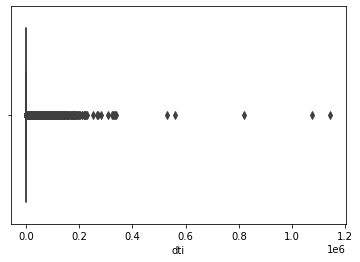

In [ ]:
sns.boxplot(df['dti'])

In [ ]:
df['dti'].describe()

count    7.071475e+06
mean     1.182206e+02
std      1.785432e+03
min     -1.000000e+00
25%      8.160000e+00
50%      2.035000e+01
75%      3.710000e+01
max      1.143590e+06
Name: dti, dtype: float64

In [ ]:
# remove rows where FICO scores are missing

df=df[df['fico_score'].notna()]

In [ ]:
# check missing values again
# Checking for missing values
total_miss_data= df.isnull().sum().sort_values(ascending=False)
percent_miss_data= (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
emp_length,0,0.0
dti,0,0.0
fico_score,0,0.0
title,0,0.0
loan_amnt,0,0.0


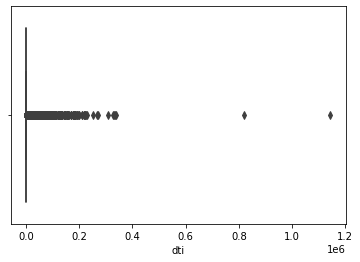

In [ ]:
sns.boxplot(df['dti'])

In [ ]:
df['dti'].describe()

count    3.826324e+06
mean     9.496456e+01
std      1.764623e+03
min     -1.000000e+00
25%      1.052000e+01
50%      2.193000e+01
75%      3.775000e+01
max      1.143590e+06
Name: dti, dtype: float64

In [ ]:
# Outlier handling
Q1 = df['dti'].quantile(0.25)
Q3 = df['dti'].quantile(0.75)
IQR = Q3 - Q1
v_low  = Q1-1.5*IQR
v_high = Q3+1.5*IQR
df_ol = df.loc[(df['dti'] > v_low) & (df['dti'] < v_high)]
df_ol.shape

(3535827, 5)

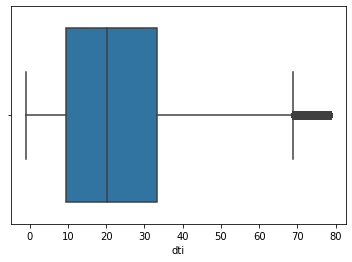

In [ ]:
sns.boxplot(df_ol['dti'])

In [ ]:
df_ol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3535827 entries, 2 to 7072572
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   loan_amnt   float64
 1   title       object 
 2   fico_score  float64
 3   dti         float64
 4   emp_length  float64
dtypes: float64(4), object(1)
memory usage: 161.9+ MB


In [ ]:
fin_df = pd.get_dummies(df_ol)
print(fin_df.shape)

(3535827, 17)


In [ ]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3535827 entries, 2 to 7072572
Data columns (total 17 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   loan_amnt                      float64
 1   fico_score                     float64
 2   dti                            float64
 3   emp_length                     float64
 4   title_Business Loan            uint8  
 5   title_Car financing            uint8  
 6   title_Credit card refinancing  uint8  
 7   title_Debt consolidation       uint8  
 8   title_Green loan               uint8  
 9   title_Home improvement         uint8  
 10  title_Learning and training    uint8  
 11  title_Major purchase           uint8  
 12  title_Medical expenses         uint8  
 13  title_Moving and relocation    uint8  
 14  title_Other                    uint8  
 15  title_Vacation                 uint8  
 16  title_house                    uint8  
dtypes: float64(4), uint8(13)
memory usage: 178.7 M

In [ ]:
fin_df['is_default']=-1
fin_df.head()

,loan_amnt,fico_score,dti,emp_length,title_Business Loan,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home improvement,title_Learning and training,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,title_house,is_default
2,1000.0,528.0,0.00,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1
13,3000.0,658.0,4.84,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1
15,20000.0,594.0,11.99,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1
17,1000.0,650.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,-1
20,1250.0,622.0,27.44,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1


In [ ]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3535827 entries, 2 to 7072572
Data columns (total 18 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   loan_amnt                      float64
 1   fico_score                     float64
 2   dti                            float64
 3   emp_length                     float64
 4   title_Business Loan            uint8  
 5   title_Car financing            uint8  
 6   title_Credit card refinancing  uint8  
 7   title_Debt consolidation       uint8  
 8   title_Green loan               uint8  
 9   title_Home improvement         uint8  
 10  title_Learning and training    uint8  
 11  title_Major purchase           uint8  
 12  title_Medical expenses         uint8  
 13  title_Moving and relocation    uint8  
 14  title_Other                    uint8  
 15  title_Vacation                 uint8  
 16  title_house                    uint8  
 17  is_default                     int64  
dtypes:

<h3> Loading Accepted records and processing </h3>

In [ ]:
path='/content/drive/My Drive/Colab Notebooks/LJMU Thesis/LC_dataset_accepted_2017.csv'
acc_df = pd.read_csv(path)

In [ ]:
acc_df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,120122535,NaN,12000.0,12000.0,12000.0,36 months,7.97,375.88,A,A5,associate,10+ years,OWN,42000.0,Source Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,923xx,CA,27.74,0.0,Jun-1996,715.0,719.0,0.0,NaN,80.0,9.0,1.0,11457.0,37.0,16.0,w,6688.31,6688.31,6397.930000,6397.93,5311.69,1086.24,0.0,0.0,0.0,Mar-2019,375.88,Apr-2019,Mar-2019,729.0,725.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,30502.0,1.0,2.0,1.0,3.0,8.0,19045.0,73.0,2.0,4.0,7117.0,53.0,31000.0,1.0,1.0,2.0,7.0,3389.0,7144.0,53.9,0.0,0.0,131.0,255.0,1.0,1.0,0.0,14.0,NaN,8.0,NaN,0.0,2.0,6.0,2.0,2.0,7.0,7.0,9.0,6.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,57180.0,30502.0,15500.0,26180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,120122034,NaN,16000.0,16000.0,16000.0,36 months,7.97,501.17,A,A5,Senior Investigator,5 years,RENT,79077.0,Not Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,223xx,VA,15.94,0.0,Jun-2000,700.0,704.0,0.0,38.0,NaN,12.0,0.0,16217.0,57.7,20.0,w,8917.81,8917.81,8511.190000,8511.19,7082.19,1429.00,0.0,0.0,0.0,Feb-2019,501.17,Apr-2019,Mar-2019,689.0,685.0,0.0,63.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,128572.0,0.0,1.0,0.0,0.0,38.0,112355.0,NaN,0.0,0.0,2959.0,58.0,28100.0,0.0,0.0,0.0,0.0,10714.0,336.0,90.9,0.0,0.0,145.0,207.0,32.0,32.0,0.0,206.0,NaN,NaN,38.0,2.0,2.0,11.0,2.0,2.0,9.0,11.0,11.0,11.0,12.0,0.0,0.0,0.0,0.0,78.9,100.0,0.0,0.0,125018.0,1

In [ ]:
a_df=acc_df[['loan_amnt','emp_length','issue_d','title','dti','fico_range_high','fico_range_low','zip_code','addr_state','policy_code','loan_status']]
a_df.head(10)

,loan_amnt,emp_length,issue_d,title,dti,fico_range_high,fico_range_low,zip_code,addr_state,policy_code,loan_status
0,12000.0,10+ years,Sep-2017,Debt consolidation,27.74,719.0,715.0,923xx,CA,1.0,Current
1,16000.0,5 years,Sep-2017,Debt consolidation,15.94,704.0,700.0,223xx,VA,1.0,Current
2,33000.0,< 1 year,Sep-2017,Debt consolidation,19.06,789.0,785.0,750xx,TX,1.0,Current
3,32000.0,10+ years,Sep-2017,Credit card refinancing,12.35,719.0,715.0,080xx,NJ,1.0,Current
4,40000.0,9 years,Sep-2017,Debt consolidation,31.11,769.0,765.0,778xx,TX,1.0,Current
5,7000.0,10+ years,Sep-2017,Debt consolidation,12.27,714.0,710.0,604xx,IL,1.0,Current
6,35000.0,10+ years,Sep-2017,Home buying,12.14,684.0,680.0,112xx,NY,1.0,Fully Paid
7,15000.0,10+ years,Sep-2017,Home improvement,15.21,699.0,695.0,335xx,FL,1.0,Current
8,22400.0,1 year,Sep-2017,Debt consolidation,22.93,729.0,725.0,334xx,FL,1.0,Current
9,10000.0,1 year,Sep-2017,Debt consolidation,49.94,709.0,705.0,412xx,KY,1.0,Fully Paid


In [ ]:
#remove unwanted columns
a_df.drop(["zip_code", "addr_state","policy_code","issue_d"], axis=1, inplace=True)

In [ ]:
# df_mean = df[["a", "b"]].mean()

In [ ]:
a_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440100 entries, 0 to 440099
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   loan_amnt        440100 non-null  float64
 1   emp_length       408230 non-null  object 
 2   title            440100 non-null  object 
 3   dti              439586 non-null  float64
 4   fico_range_high  440100 non-null  float64
 5   fico_range_low   440100 non-null  float64
 6   loan_status      440100 non-null  object 
dtypes: float64(4), object(3)
memory usage: 23.5+ MB


In [ ]:
total_miss_data= a_df.isnull().sum().sort_values(ascending=False)
percent_miss_data= (a_df.isnull().sum()/a_df.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
emp_length,31870,7.241536
dti,514,0.116792
loan_status,0,0.000000
fico_range_low,0,0.000000
fico_range_high,0,0.000000
title,0,0.000000
loan_amnt,0,0.000000


In [ ]:
# calculate fico score as a mean of fico_score_low and fico_score_high
a_df["fico_score"] = a_df[["fico_range_low", "fico_range_high"]].mean()

In [ ]:
a_df.head()

,loan_amnt,emp_length,title,dti,fico_range_high,fico_range_low,loan_status,fico_score
0,12000.0,10+ years,Debt consolidation,27.74,719.0,715.0,Current,NaN
1,16000.0,5 years,Debt consolidation,15.94,704.0,700.0,Current,NaN
2,33000.0,< 1 year,Debt consolidation,19.06,789.0,785.0,Current,NaN
3,32000.0,10+ years,Credit card refinancing,12.35,719.0,715.0,Current,NaN
4,40000.0,9 years,Debt consolidation,31.11,769.0,765.0,Current,NaN


In [ ]:
col = a_df.loc[: , "fico_range_high":"fico_range_low"]

In [ ]:
a_df['fico_score'] = col.mean(axis=1)
a_df.head(20)

,loan_amnt,emp_length,title,dti,fico_range_high,fico_range_low,loan_status,fico_score
0,12000.0,10+ years,Debt consolidation,27.74,719.0,715.0,Current,717.0
1,16000.0,5 years,Debt consolidation,15.94,704.0,700.0,Current,702.0
2,33000.0,< 1 year,Debt consolidation,19.06,789.0,785.0,Current,787.0
3,32000.0,10+ years,Credit card refinancing,12.35,719.0,715.0,Current,717.0
4,40000.0,9 years,Debt consolidation,31.11,769.0,765.0,Current,767.0
5,7000.0,10+ years,Debt consolidation,12.27,714.0,710.0,Current,712.0
6,35000.0,10+ years,Home buying,12.14,684.0,680.0,Fully Paid,682.0
7,15000.0,10+ years,Home improvement,15.21,699.0,695.0,Current,697.0
8,22400.0,1 year,Debt consolidation,22.93,729.0,725.0,Current,727.0
9,10000.0,1 year,Debt consolidation,49.94,709.0,705.0,Fully Paid,707.0


In [ ]:
# converting the column into integer
a_df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
a_df['emp_length'].replace(to_replace='< 1 year', value='0 year', inplace=True)
a_df['emp_length'].value_counts(dropna=False)

10 years    144821
0 year       43496
2 years      40116
3 years      35057
NaN          31870
1 year       28753
4 years      26776
5 years      26436
6 years      18881
7 years      15783
9 years      15080
8 years      13031
Name: emp_length, dtype: int64

In [ ]:
# Using the above logic to convert emp_length to integer and leaving null values behind
def convert_to_int(x):
    if pd.isnull(x):
        return x
    else:
        return np.int8(x.split()[0])

In [ ]:
a_df["emp_length"] = a_df["emp_length"].apply(convert_to_int)
a_df["emp_length"].value_counts(dropna=False)
a_df['emp_length'] =a_df['emp_length'].fillna(a_df['emp_length'].median())

In [ ]:
a_df["emp_length"].value_counts(dropna=False)

10.0    144821
6.0      50751
0.0      43496
2.0      40116
3.0      35057
1.0      28753
4.0      26776
5.0      26436
7.0      15783
9.0      15080
8.0      13031
Name: emp_length, dtype: int64

In [ ]:
a_df.drop(["fico_range_high", "fico_range_low"], axis=1, inplace=True)

In [ ]:
def is_default(x):
    if x=='Default' or x=='Late (31-120 days)' or x=='Charged Off':
        return 1
    elif x=='Fully Paid':
        return 0
    elif x=='Current' or x=='Late (16-30 days)' or x=='In Grace Period':
        return -1

In [ ]:
a_df["is_default"] = a_df["loan_status"].apply(is_default)

In [ ]:
a_df["is_default"].value_counts(dropna=False)

-1    264053
 0    129119
 1     46928
Name: is_default, dtype: int64

In [ ]:
a_df.drop(["loan_status"], axis=1, inplace=True)

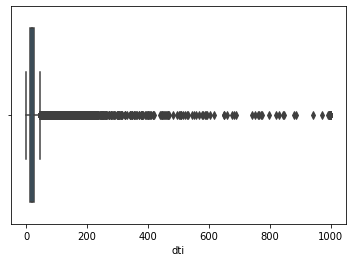

In [ ]:
sns.boxplot(a_df['dti'])

In [ ]:
#handling outliers
# Outlier handling
Q1 = a_df['dti'].quantile(0.25)
Q3 = a_df['dti'].quantile(0.75)
IQR = Q3 - Q1
v_low  = Q1-1.5*IQR
v_high = Q3+1.5*IQR
a_df_ol = a_df.loc[(a_df['dti'] > v_low) & (a_df['dti'] < v_high)]
a_df_ol.shape

(432845, 6)

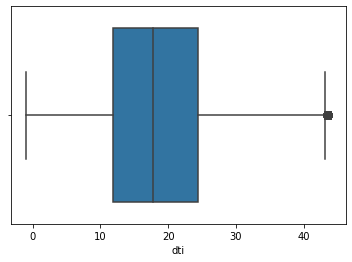

In [ ]:
sns.boxplot(a_df_ol['dti'])

In [ ]:
total_miss_data= a_df_ol.isnull().sum().sort_values(ascending=False)
percent_miss_data= (a_df_ol.isnull().sum()/a_df_ol.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
is_default,0,0.0
fico_score,0,0.0
dti,0,0.0
title,0,0.0
emp_length,0,0.0
loan_amnt,0,0.0


In [ ]:
a_df_ol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432845 entries, 0 to 440099
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   loan_amnt   432845 non-null  float64
 1   emp_length  432845 non-null  float64
 2   title       432845 non-null  object 
 3   dti         432845 non-null  float64
 4   fico_score  432845 non-null  float64
 5   is_default  432845 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 23.1+ MB


In [ ]:
fa_df = pd.get_dummies(a_df_ol)
print(fa_df.shape)

(432845, 18)


In [ ]:
fa_df.columns

Index(['loan_amnt', 'emp_length', 'dti', 'fico_score', 'is_default',
       'title_Business', 'title_Car financing',
       'title_Credit card refinancing', 'title_Debt consolidation',
       'title_Green loan', 'title_Home buying', 'title_Home improvement',
       'title_Learning and training', 'title_Major purchase',
       'title_Medical expenses', 'title_Moving and relocation', 'title_Other',
       'title_Vacation'],
      dtype='object')

In [ ]:
fin_df.columns

Index(['loan_amnt', 'fico_score', 'dti', 'emp_length', 'title_Business Loan',
       'title_Car financing', 'title_Credit card refinancing',
       'title_Debt consolidation', 'title_Green loan',
       'title_Home improvement', 'title_Learning and training',
       'title_Major purchase', 'title_Medical expenses',
       'title_Moving and relocation', 'title_Other', 'title_Vacation',
       'title_house', 'is_default'],
      dtype='object')

In [ ]:
fa_df.rename(columns={"title_Business": "title_Business Loan", "title_Home buying": "title_house"},inplace=True)

In [ ]:
fa_df.columns

Index(['loan_amnt', 'emp_length', 'dti', 'fico_score', 'is_default',
       'title_Business Loan', 'title_Car financing',
       'title_Credit card refinancing', 'title_Debt consolidation',
       'title_Green loan', 'title_house', 'title_Home improvement',
       'title_Learning and training', 'title_Major purchase',
       'title_Medical expenses', 'title_Moving and relocation', 'title_Other',
       'title_Vacation'],
      dtype='object')

<h3> Sampling both accepted and rejected data frames and merging them <h3>

In [ ]:
# rejected records
# Sampling the data in random for 1 lakh records
samp_r = np.random.permutation(300000)
fr_df_rand = fin_df.take(samp_r)

In [ ]:
# accepted records
samp_a = np.random.permutation(30000)
fa_df_rand = fa_df.take(samp_a)

In [ ]:
fr_df_rand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 117148 to 65769
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      300000 non-null  float64
 1   fico_score                     300000 non-null  float64
 2   dti                            300000 non-null  float64
 3   emp_length                     300000 non-null  float64
 4   title_Business Loan            300000 non-null  uint8  
 5   title_Car financing            300000 non-null  uint8  
 6   title_Credit card refinancing  300000 non-null  uint8  
 7   title_Debt consolidation       300000 non-null  uint8  
 8   title_Green loan               300000 non-null  uint8  
 9   title_Home improvement         300000 non-null  uint8  
 10  title_Learning and training    300000 non-null  uint8  
 11  title_Major purchase           300000 non-null  uint8  
 12  title_Medical expenses    

In [ ]:
fa_df_rand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 11045 to 14162
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   loan_amnt                      30000 non-null  float64
 1   emp_length                     30000 non-null  float64
 2   dti                            30000 non-null  float64
 3   fico_score                     30000 non-null  float64
 4   is_default                     30000 non-null  int64  
 5   title_Business Loan            30000 non-null  uint8  
 6   title_Car financing            30000 non-null  uint8  
 7   title_Credit card refinancing  30000 non-null  uint8  
 8   title_Debt consolidation       30000 non-null  uint8  
 9   title_Green loan               30000 non-null  uint8  
 10  title_house                    30000 non-null  uint8  
 11  title_Home improvement         30000 non-null  uint8  
 12  title_Learning and training    30000 non-n

In [ ]:
dfs = [fa_df_rand,fr_df_rand]
cdf=pd.concat(dfs)
cdf

,loan_amnt,emp_length,dti,fico_score,is_default,title_Business Loan,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_house,title_Home improvement,title_Learning and training,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation
11045,20000.0,8.0,21.06,672.0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0
16163,3000.0,5.0,5.64,702.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
11766,10000.0,10.0,21.38,662.0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0
26011,15000.0,10.0,21.28,662.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
16925,28800.0,10.0,13.00,687.0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361653,25000.0,0.0,21.59,628.0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0
639271,40000.0,0.0,39.57,674.0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0
345309,20000.0,0.0,45.40,631.0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0
822445,35000.0,0.0,35.20,661.0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330000 entries, 11045 to 65769
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      330000 non-null  float64
 1   emp_length                     330000 non-null  float64
 2   dti                            330000 non-null  float64
 3   fico_score                     330000 non-null  float64
 4   is_default                     330000 non-null  int64  
 5   title_Business Loan            330000 non-null  uint8  
 6   title_Car financing            330000 non-null  uint8  
 7   title_Credit card refinancing  330000 non-null  uint8  
 8   title_Debt consolidation       330000 non-null  uint8  
 9   title_Green loan               330000 non-null  uint8  
 10  title_house                    330000 non-null  uint8  
 11  title_Home improvement         330000 non-null  uint8  
 12  title_Learning and training

Feature selection

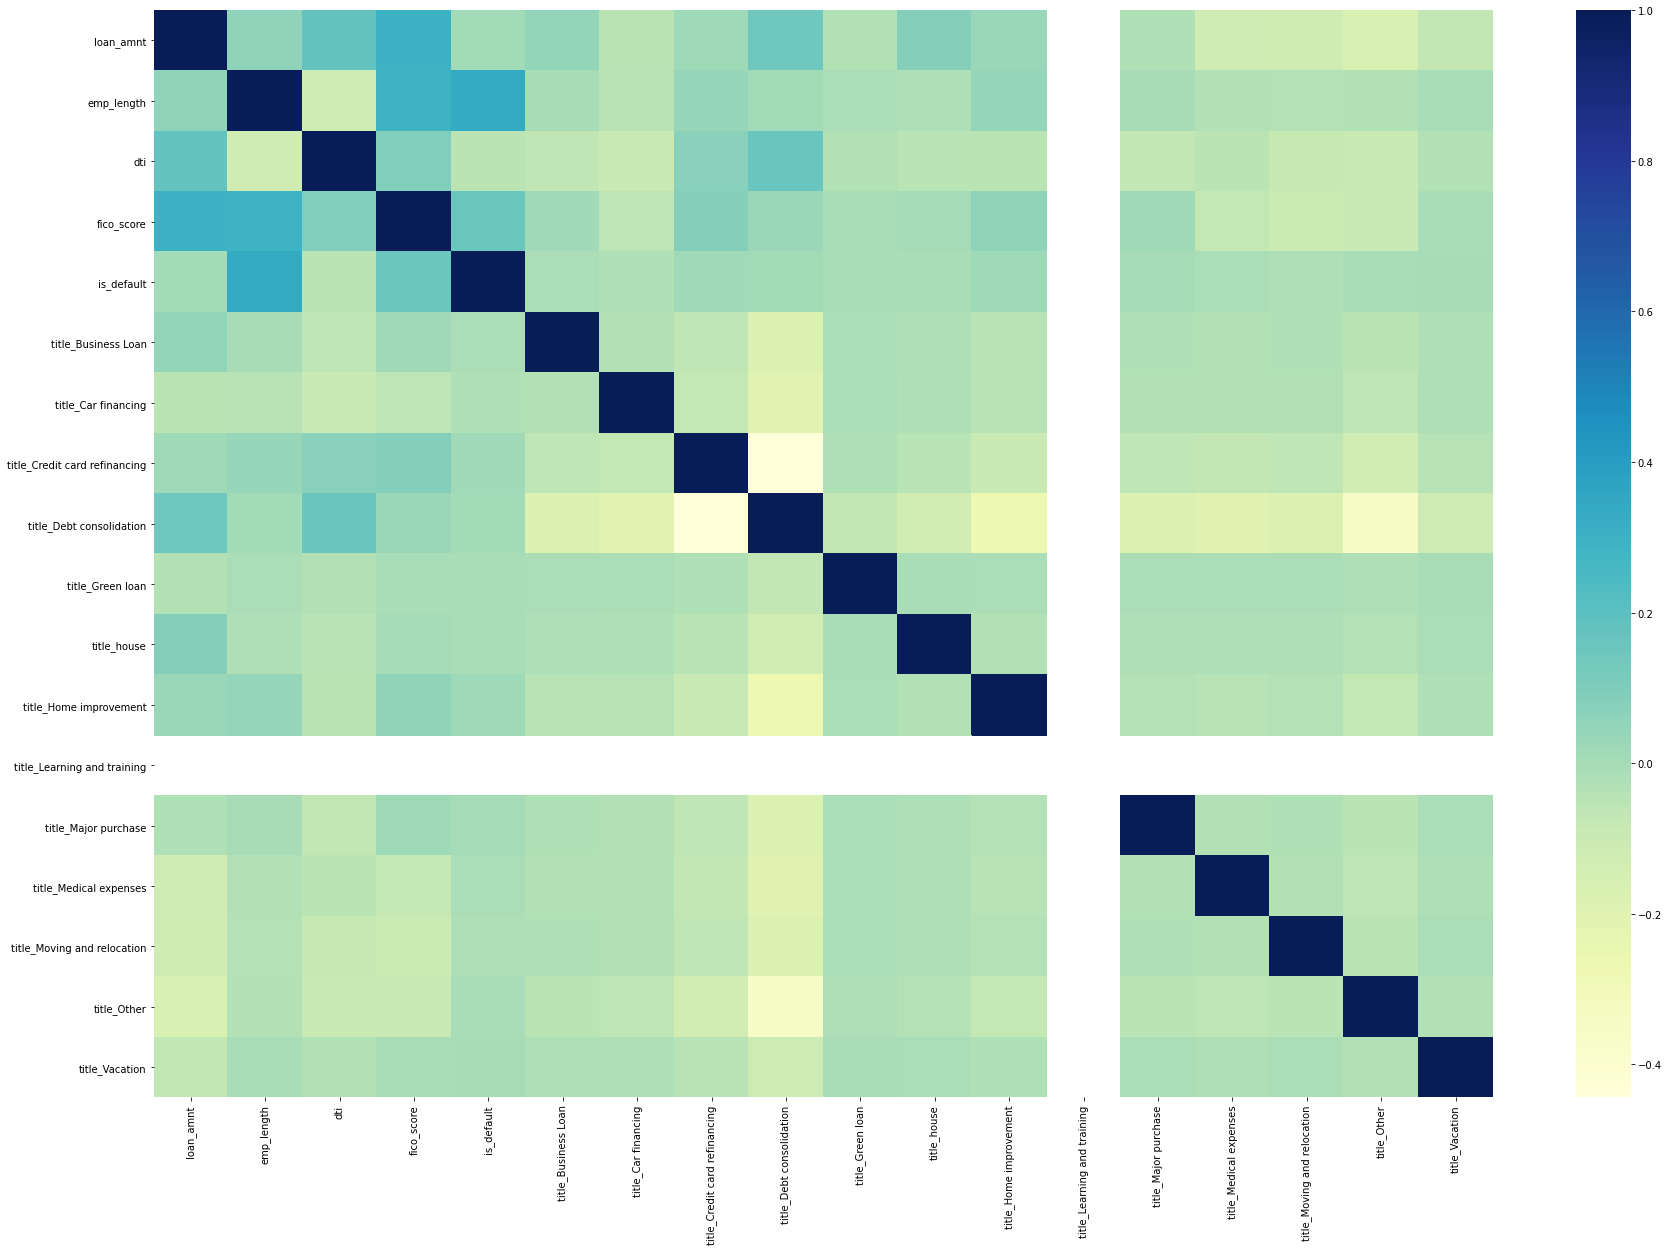

In [ ]:
# check correlation map
plt.figure(figsize=(30,20))
sns.heatmap(cdf.corr(), cmap="YlGnBu")
plt.show()

In [ ]:
X=cdf.drop('is_default',axis=1)
y=cdf['is_default']

<h3> Standardisation <h3>

In [ ]:
# Standardising values:
from sklearn import preprocessing
sc = preprocessing.MinMaxScaler()
# Fit your data on the scaler object

var_col=cdf.select_dtypes('float64').columns

X[var_col] = sc.fit_transform(X[var_col])
X.head()

,loan_amnt,emp_length,dti,fico_score,title_Business Loan,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_house,title_Home improvement,title_Learning and training,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation
11045,0.487179,0.8,0.277170,0.539130,0,0,0,1,0,0,0,0,0,0,0,0,0
16163,0.051282,0.5,0.083428,0.582609,0,0,0,0,0,0,1,0,0,0,0,0,0
11766,0.230769,1.0,0.281191,0.524638,0,0,0,1,0,0,0,0,0,0,0,0,0
26011,0.358974,1.0,0.279935,0.524638,0,0,0,1,0,0,0,0,0,0,0,0,0
16925,0.712821,1.0,0.175901,0.560870,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

label_spread_knn = LabelSpreading(kernel='knn',n_neighbors=1)


In [ ]:
label_spread_knn.fit(X, y)
y_predict_spread_knn = label_spread_knn.predict(X)

In [ ]:
y_predict_spread_knn_df=pd.DataFrame(y_predict_spread_knn)
y_predict_spread_knn_df.value_counts()

0    326986
1      3014
dtype: int64

In [ ]:
def print_metrics(y_train, y_test, y_train_pred, y_test_pred, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, y_train_pred)))
        print("Classification Report: \n {}\n".format(classification_report(y_train, y_train_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, y_train_pred)))
        #res = cross_val_score(samp_model, X_train, y_train, cv=10, scoring='accuracy')
        #print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        #print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_test_pred)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, y_test_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_test_pred)))
        print('ROC-AUC score:',roc_auc_score(y_test, y_test_pred))

Train test split

In [ ]:
#Splitting into train test split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X,y_predict_spread_knn,test_size=0.15,random_state=101)

Logistic Regression without class balancing


In [ ]:
lr = LogisticRegression()
model_lr_s = lr.fit(X_train_s,y_train_s)



In [ ]:
# Traning metrics
y_train_lr_pred = model_lr_s.predict(X_train_s)
y_test_lr_pred = model_lr_s.predict(X_test_s)
print_metrics(y_train_s, y_test_s, y_train_lr_pred, y_test_lr_pred,train=True)

Train Result:

accuracy score: 0.9909

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    277944
           1       0.00      0.00      0.00      2556

    accuracy                           0.99    280500
   macro avg       0.50      0.50      0.50    280500
weighted avg       0.98      0.99      0.99    280500


Confusion Matrix: 
 [[277944      0]
 [  2556      0]]



In [ ]:
print_metrics(y_train_s, y_test_s,y_train_lr_pred, y_test_lr_pred,train=False)

Test Result:

accuracy score: 0.9907

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     49040
           1       0.00      0.00      0.00       460

    accuracy                           0.99     49500
   macro avg       0.50      0.50      0.50     49500
weighted avg       0.98      0.99      0.99     49500


Confusion Matrix: 
 [[49040     0]
 [  460     0]]

ROC-AUC score: 0.5


Random forests without balancing

In [ ]:
rfc = RandomForestClassifier()
model_rfc_s = rfc.fit(X_train_s,y_train_s)

In [ ]:
# Traning metrics
y_train_rfc_pred = model_rfc_s.predict(X_train_s)
y_test_rfc_pred = model_rfc_s.predict(X_test_s)
print_metrics(y_train_s, y_test_s, y_train_rfc_pred, y_test_rfc_pred,train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    277944
           1       1.00      1.00      1.00      2556

    accuracy                           1.00    280500
   macro avg       1.00      1.00      1.00    280500
weighted avg       1.00      1.00      1.00    280500


Confusion Matrix: 
 [[277944      0]
 [     5   2551]]



In [ ]:
print_metrics(y_train_s, y_test_s,y_train_rfc_pred, y_test_rfc_pred,train=False)

Test Result:

accuracy score: 0.9903

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     49040
           1       0.14      0.01      0.02       460

    accuracy                           0.99     49500
   macro avg       0.57      0.50      0.51     49500
weighted avg       0.98      0.99      0.99     49500


Confusion Matrix: 
 [[49016    24]
 [  456     4]]

ROC-AUC score: 0.50410312788141


With TOMEK Links - under sampling

In [ ]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority')

In [ ]:
X_train_s_tl, y_train_s_tl = tl.fit_resample(X_train_s, y_train_s)


In [ ]:
lr = LogisticRegression()
model_lr_s_tl = lr.fit(X_train_s_tl,y_train_s_tl)

In [ ]:
# Traning metrics
y_train_lr_pred = model_lr_s_tl.predict(X_train_s_tl)
y_test_lr_pred = model_lr_s_tl.predict(X_test_s)
print_metrics(y_train_s_tl, y_test_s, y_train_lr_pred, y_test_lr_pred,train=True)

Train Result:

accuracy score: 0.9908

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    276602
           1       0.00      0.00      0.00      2556

    accuracy                           0.99    279158
   macro avg       0.50      0.50      0.50    279158
weighted avg       0.98      0.99      0.99    279158


Confusion Matrix: 
 [[276602      0]
 [  2556      0]]



In [ ]:
print_metrics(y_train_s_tl, y_test_s, y_train_lr_pred, y_test_lr_pred,train=False)

Train Result:

accuracy score: 0.9908

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    276602
           1       0.00      0.00      0.00      2556

    accuracy                           0.99    279158
   macro avg       0.50      0.50      0.50    279158
weighted avg       0.98      0.99      0.99    279158


Confusion Matrix: 
 [[276602      0]
 [  2556      0]]



In [ ]:
rfc = RandomForestClassifier()
model_rfc_s_tl = rfc.fit(X_train_s_tl,y_train_s_tl)

In [ ]:
# Traning metrics
y_train_rfc_pred = model_rfc_s_tl.predict(X_train_s_tl)
y_test_rfc_pred = model_rfc_s_tl.predict(X_test_s)
print_metrics(y_train_s_tl, y_test_s, y_train_rfc_pred, y_test_rfc_pred,train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    276602
           1       1.00      1.00      1.00      2556

    accuracy                           1.00    279158
   macro avg       1.00      1.00      1.00    279158
weighted avg       1.00      1.00      1.00    279158


Confusion Matrix: 
 [[276602      0]
 [     2   2554]]



In [ ]:
print_metrics(y_train_s_tl, y_test_s, y_train_rfc_pred, y_test_rfc_pred,train=False)

Test Result:

accuracy score: 0.9902

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     49040
           1       0.16      0.01      0.02       460

    accuracy                           0.99     49500
   macro avg       0.57      0.51      0.51     49500
weighted avg       0.98      0.99      0.99     49500


Confusion Matrix: 
 [[49008    32]
 [  454     6]]

ROC-AUC score: 0.5061954748563727


Label propagation

In [ ]:
# Learn with LabelSpreading with default values - default being SVM
label_prop = LabelPropagation(kernel='knn', n_neighbors=1)
label_prop.fit(X, y)


LabelPropagation(gamma=20, kernel='knn', max_iter=1000, n_jobs=None,
                 n_neighbors=1, tol=0.001)

In [ ]:
y_prop_predicted_labels=label_prop.predict(X)

In [ ]:
y_prop_predicted_labels_df=pd.DataFrame(y_prop_predicted_labels)
y_prop_predicted_labels_df.value_counts()

0    326978
1      3022
dtype: int64

Train test split

In [ ]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X,y_prop_predicted_labels,test_size=0.15,random_state=101)

Model generations 

Logistic Regression

In [ ]:
lr = LogisticRegression()
model_lr_p = lr.fit(X_train_p,y_train_p)

In [ ]:
y_train_lr_p_pred = model_lr_p.predict(X_train_p)
y_test_lr_p_pred = model_lr_p.predict(X_test_p)
print_metrics(y_train_p, y_test_p, y_train_lr_p_pred, y_test_lr_p_pred,train=True)

Train Result:

accuracy score: 0.9908

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    277915
           1       0.00      0.00      0.00      2585

    accuracy                           0.99    280500
   macro avg       0.50      0.50      0.50    280500
weighted avg       0.98      0.99      0.99    280500


Confusion Matrix: 
 [[277915      0]
 [  2585      0]]



In [ ]:
print_metrics(y_train_p, y_test_p, y_train_lr_p_pred, y_test_lr_p_pred,train=False)

Test Result:

accuracy score: 0.9912

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     49063
           1       0.00      0.00      0.00       437

    accuracy                           0.99     49500
   macro avg       0.50      0.50      0.50     49500
weighted avg       0.98      0.99      0.99     49500


Confusion Matrix: 
 [[49063     0]
 [  437     0]]

ROC-AUC score: 0.5


Random forests

In [ ]:
rfc = RandomForestClassifier()
model_rfc_p = rfc.fit(X_train_p,y_train_p)

In [ ]:
y_train_rfc_p_pred = model_rfc_p.predict(X_train_p)
y_test_rfc_p_pred = model_rfc_p.predict(X_test_p)
print_metrics(y_train_p, y_test_p, y_train_rfc_p_pred, y_test_rfc_p_pred,train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    277915
           1       1.00      1.00      1.00      2585

    accuracy                           1.00    280500
   macro avg       1.00      1.00      1.00    280500
weighted avg       1.00      1.00      1.00    280500


Confusion Matrix: 
 [[277915      0]
 [     5   2580]]



In [ ]:
print_metrics(y_train_p, y_test_p, y_train_rfc_p_pred, y_test_rfc_p_pred,train=False)

Test Result:

accuracy score: 0.9907

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     49063
           1       0.18      0.01      0.03       437

    accuracy                           0.99     49500
   macro avg       0.58      0.51      0.51     49500
weighted avg       0.98      0.99      0.99     49500


Confusion Matrix: 
 [[49035    28]
 [  431     6]]

ROC-AUC score: 0.5065796411478801


With class balancing -  Tomek Links

In [ ]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority')

In [ ]:
X_train_p_tl, y_train_p_tl = tl.fit_resample(X_train_p, y_train_p)

Logistic Regression

In [ ]:
lr = LogisticRegression()
model_lr_p_tl = lr.fit(X_train_p_tl,y_train_p_tl)

In [ ]:
# Traning metrics
y_train_lr_p_pred = model_lr_p_tl.predict(X_train_p_tl)
y_test_lr_p_pred = model_lr_p_tl.predict(X_test_p)
print_metrics(y_train_p_tl, y_test_p, y_train_lr_p_pred, y_test_lr_p_pred,train=True)

Train Result:

accuracy score: 0.9907

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    276559
           1       0.00      0.00      0.00      2585

    accuracy                           0.99    279144
   macro avg       0.50      0.50      0.50    279144
weighted avg       0.98      0.99      0.99    279144


Confusion Matrix: 
 [[276559      0]
 [  2585      0]]



In [ ]:
print_metrics(y_train_p_tl, y_test_p, y_train_lr_p_pred, y_test_lr_p_pred,train=False)

Test Result:

accuracy score: 0.9912

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     49063
           1       0.00      0.00      0.00       437

    accuracy                           0.99     49500
   macro avg       0.50      0.50      0.50     49500
weighted avg       0.98      0.99      0.99     49500


Confusion Matrix: 
 [[49063     0]
 [  437     0]]

ROC-AUC score: 0.5


Random forests

In [ ]:
rfc = RandomForestClassifier()
model_rfc_p_tl = rfc.fit(X_train_p_tl,y_train_p_tl)

In [ ]:
# Traning metrics
y_train_rfc_p_pred = model_rfc_p_tl.predict(X_train_p_tl)
y_test_rfc_p_pred = model_rfc_p_tl.predict(X_test_p)
print_metrics(y_train_p_tl, y_test_p, y_train_rfc_p_pred, y_test_rfc_p_pred,train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    276559
           1       1.00      1.00      1.00      2585

    accuracy                           1.00    279144
   macro avg       1.00      1.00      1.00    279144
weighted avg       1.00      1.00      1.00    279144


Confusion Matrix: 
 [[276559      0]
 [     3   2582]]



In [ ]:
print_metrics(y_train_p_tl, y_test_p, y_train_rfc_p_pred, y_test_rfc_p_pred,train=False)

Test Result:

accuracy score: 0.9906

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     49063
           1       0.20      0.02      0.04       437

    accuracy                           0.99     49500
   macro avg       0.60      0.51      0.52     49500
weighted avg       0.98      0.99      0.99     49500


Confusion Matrix: 
 [[49024    39]
 [  427    10]]

ROC-AUC score: 0.511044199418382


================================================================================

In [ ]:
# Remove missing value columns for hardship plan introduced in March 2017 for a selective borrowers. About 99.99% data is missing. Removing the columns

df.drop(["member_id", "desc", "orig_projected_additional_accrued_interest","hardship_end_date","deferral_term","payment_plan_start_date"], axis=1, inplace=True)
df.drop(["hardship_length", "hardship_dpd", "hardship_loan_status","hardship_last_payment_amount","hardship_payoff_balance_amount","hardship_amount"], axis=1, inplace=True)
df.drop(["hardship_status", "hardship_reason", "hardship_type","hardship_start_date"], axis=1, inplace=True)

# Removing settlement related attributes that were introduced in Sep 2017 as part of settlement - More than 99% data is missing, removing them

df.drop(["settlement_term", "settlement_percentage", "debt_settlement_flag_date","settlement_status","settlement_date","settlement_amount","sec_app_mths_since_last_major_derog"], axis=1, inplace=True)
df.drop(["sec_app_revol_util", "verification_status_joint", "revol_bal_joint","sec_app_inq_last_6mths","sec_app_fico_range_low","sec_app_fico_range_high","sec_app_earliest_cr_line","sec_app_mort_acc","sec_app_open_acc","sec_app_open_act_il"], axis=1, inplace=True)
df.drop(["sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med","annual_inc_joint","dti_joint"], axis=1, inplace=True)


In [ ]:
#Checking for missing data post 1st level of cleanup

total_miss_data= df.isnull().sum().sort_values(ascending=False)
percent_miss_data= (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
mths_since_last_record,712698,81.840292
mths_since_recent_bc_dlq,658756,75.646043
mths_since_last_major_derog,628531,72.175256
mths_since_recent_revol_delinq,566759,65.081875
next_pymnt_d,458737,52.677530
mths_since_last_delinq,424125,48.702976
il_util,118424,13.598824
mths_since_recent_inq,96529,11.084585
emp_title,60837,6.986014
emp_length,60083,6.899430


In [ ]:
# Handling missing values and imputing them with median wherever necessary
# 1. inq_last_6mths - The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
df['inq_last_6mths'].median()
df['inq_last_6mths'].value_counts(dropna=False)

# Impute the missing value NaN with median
df['inq_last_6mths'] =df['inq_last_6mths'].fillna(df['inq_last_6mths'].median())
# Verify the NaN values 
df['inq_last_6mths'].value_counts(dropna=False)

0.0    546411
1.0    223586
2.0     70998
3.0     21818
4.0      5989
5.0      2038
Name: inq_last_6mths, dtype: int64

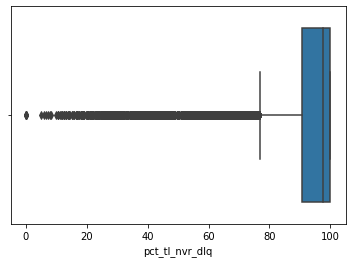

In [ ]:
# 2. pct_tl_nvr_dlq - Percent of trades never delinquent
df['pct_tl_nvr_dlq'].value_counts(dropna=False)
sns.boxplot(df['pct_tl_nvr_dlq'])

df['pct_tl_nvr_dlq'].median()
df['pct_tl_nvr_dlq'].mean()
df['pct_tl_nvr_dlq'].mode()

df['pct_tl_nvr_dlq'] =df['pct_tl_nvr_dlq'].fillna(df['pct_tl_nvr_dlq'].median())

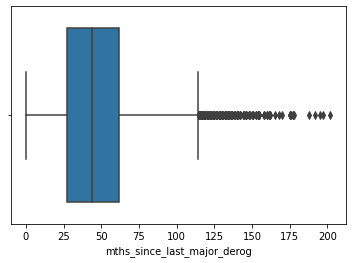

In [ ]:
# 3. mths_since_last_major_derog - Months since most recent 90-day or worse rating
df['mths_since_last_major_derog'].value_counts(dropna=False)

#removing the column where more than 70% data is missing
sns.boxplot(df['mths_since_last_major_derog'])

df['mths_since_last_major_derog'].median()
df['mths_since_last_major_derog'].mode()
df['mths_since_last_major_derog'].mean()

df.drop(["mths_since_last_major_derog"], axis=1, inplace=True)

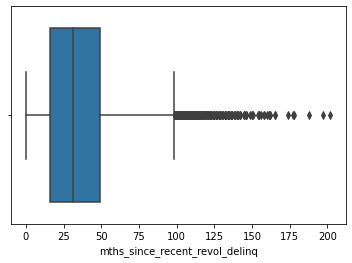

In [ ]:
# mths_since_recent_revol_delinq - Months since most recent revolving delinquency.
sns.boxplot(df['mths_since_recent_revol_delinq'])
df['mths_since_recent_revol_delinq'].mean()
df['mths_since_recent_revol_delinq'].median()
df['mths_since_recent_revol_delinq'].mode()

# Imputing the value with 0. Because not all borrowers may not deliquent
df['mths_since_recent_revol_delinq'].fillna(0,inplace=True)

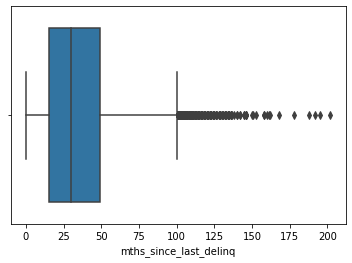

In [ ]:
# mths_since_last_delinq - The number of months since the borrower's last delinquency.
df['mths_since_last_delinq'].value_counts(dropna=False)
sns.boxplot(df['mths_since_last_delinq'])
df['mths_since_last_delinq'].median()
df['mths_since_last_delinq'].mode()
df['mths_since_last_delinq'].mean()

# Imputing the value with median 
df['mths_since_last_delinq'] =df['mths_since_last_delinq'].fillna(df['mths_since_last_delinq'].median())

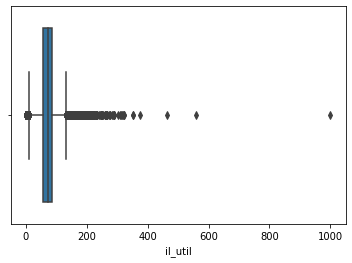

In [ ]:
# il_util - Ratio of total current balance to high credit/credit limit on all install acct
df['il_util'].value_counts(dropna=False)
sns.boxplot(df['il_util'])

df['il_util'].mode()
df['il_util'].median()
df['il_util'].mean()

df['il_util'] =df['il_util'].fillna(df['il_util'].median())

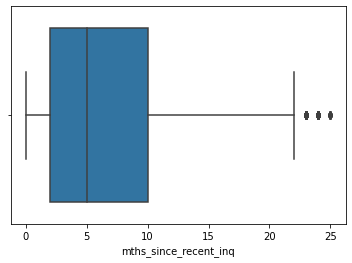

In [ ]:
# mths_since_recent_inq - Months since most recent inquiry.
sns.boxplot(df['mths_since_recent_inq'])
df['mths_since_recent_inq'].value_counts(dropna=False)
df['mths_since_recent_inq'].median()

# Imputing the value with median
df['mths_since_recent_inq'] =df['mths_since_recent_inq'].fillna(df['mths_since_recent_inq'].median())

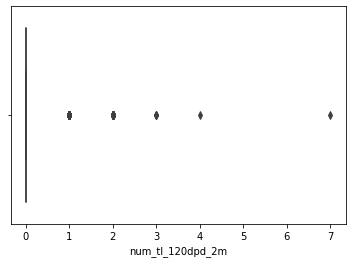

In [ ]:
# num_tl_120dpd_2m - Number of accounts currently 120 days past due (updated in past 2 months)
sns.boxplot(df['num_tl_120dpd_2m'])
df['num_tl_120dpd_2m'].value_counts(dropna=False)
df['num_tl_120dpd_2m'] =df['num_tl_120dpd_2m'].fillna(df['num_tl_120dpd_2m'].median())

In [ ]:
# Impute values with median - removed 'num_mths_for_next_pymnt'
col=['mths_since_rcnt_il','mo_sin_old_il_acct','bc_util','percent_bc_gt_75','bc_open_to_buy','mths_since_recent_bc','revol_util','all_util','open_acc_6m','total_cu_tl','inq_last_12m','max_bal_bc','open_rv_24m','open_il_12m','open_il_24m','inq_fi','total_bal_il','open_act_il','open_rv_12m','avg_cur_bal']
df[col]=df[col].fillna(df[col].median())
df.isnull().sum()

id                                     0
loan_amnt                              0
funded_amnt                            0
funded_amnt_inv                        0
term                                   0
int_rate                               0
installment                            0
grade                                  0
sub_grade                              0
emp_title                          60837
emp_length                         60083
home_ownership                         0
annual_inc                             0
verification_status                    0
issue_d                                0
loan_status                            0
pymnt_plan                             0
url                                    0
purpose                                0
title                              23088
zip_code                               1
addr_state                             0
dti                                  577
delinq_2yrs                            0
earliest_cr_line

In [ ]:
df.dtypes.value_counts().sort_values()

int64       1
object     24
float64    87
dtype: int64

In [ ]:
# Gives number of unique values for each category
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                         2
grade                        7
sub_grade                   35
emp_title               199645
emp_length                  11
home_ownership               5
verification_status          3
issue_d                     24
loan_status                  7
pymnt_plan                   2
url                     870840
purpose                     14
title                       14
zip_code                   923
addr_state                  50
earliest_cr_line           707
initial_list_status          2
last_pymnt_d                39
next_pymnt_d                 4
last_credit_pull_d          41
application_type             2
hardship_flag                2
disbursement_method          2
debt_settlement_flag         2
dtype: int64

<h3> Data cleaning </h3>

In [ ]:
# Dropping unwanted columns like id, url etc., that doesn't help in the analysis
df.drop(["id","url","zip_code","addr_state"], axis=1, inplace=True)

In [ ]:
df.info(max_cols=110)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870840 entries, 0 to 870839
Data columns (total 108 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_amnt                       870840 non-null  float64
 1   funded_amnt                     870840 non-null  float64
 2   funded_amnt_inv                 870840 non-null  float64
 3   term                            870840 non-null  object 
 4   int_rate                        870840 non-null  float64
 5   installment                     870840 non-null  float64
 6   grade                           870840 non-null  object 
 7   sub_grade                       870840 non-null  object 
 8   emp_title                       810003 non-null  object 
 9   emp_length                      810757 non-null  object 
 10  home_ownership                  870840 non-null  object 
 11  annual_inc                      870840 non-null  float64
 12  verification_st

In [ ]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,10000.0,10000.0,10000.0,60 months,13.49,230.05,C,C2,Customer Service,3 years,RENT,32000.0,Not Verified,Jun-2016,Fully Paid,n,debt_consolidation,Debt consolidation,13.05,0.0,Apr-1999,750.0,754.0,1.0,30.0,NaN,5.0,0.0,16525.0,47.3,10.0,w,0.00,0.00,10356.270252,10356.27,10000.00,356.27,0.0,0.0,0.0,Oct-2017,454.31,NaN,Oct-2017,769.0,765.0,0.0,1.0,Individual,0.0,0.0,112399.0,0.0,0.0,0.0,0.0,67.0,0.0,73.0,0.0,0.0,9296.0,47.0,34900.0,1.0,0.0,1.0,0.0,22480.0,18375.0,47.3,0.0,0.0,94.0,206.0,84.0,67.0,1.0,84.0,NaN,6.0,0.0,0.0,2.0,2.0,4.0,7.0,2.0,4.0,7.0,2.0,5.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,141464.0,16525.0,34900.0,0.0,N,Cash,N
1,12000.0,12000.0,12000.0,36 months,15.59,419.46,C,C5,Executive Assistant,7 years,MORTGAGE,70000.0,Verified,Jun-2016,Late (31-120 days),n,debt_consolidation,Debt consolidation,22.86,0.0,Aug-2000,695.0,699.0,1.0,30.0,NaN,18.0,0.0,20075.0,56.7,45.0,f,2406.15,2406.15,12479.870000,12479.87,9593.85,2886.02,0.0,0.0,0.0,Dec-2018,419.46,Apr-2019,Mar-2019,619.0,615.0,0.0,1.0,Individual,0.0,0.0,156605.0,2.0,3.0,1.0,1.0,4.0,31445.0,74.0,1.0,5.0,6031.0,66.0,35400.0,0.0,2.0,3.0,6.0,9212.0,140.0,99.1,0.0,0.0,120.0,190.0,2.0,2.0,1.0,13.0,NaN,2.0,0.0,0.0,5.0,8.0,5.0,13.0,12.0,14.0,32.0,8.0,18.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,191070.0,51520.0,15200.0,42753.0,N,Cash,N
2,4900.0,4900.0,4900.0,36 months,10.99,160.40,B,B4,Campaign Manager,< 1 year,MORTGAGE,120000.0,Verified,Jun-2016,Current,n,home_improvement,Home improvement,6.07,0.0,Mar-2003,680.0,684.0,0.0,49.0,NaN,5.0,0.0,7244.0,80.5,8.0,f,627.03,627.03,5125.320000,5125.32,4272.97,852.35,0.0,0.0,0.0,Feb-2019,160.40,Apr-2019,Mar-2019,739.0,735.0,0.0,1.0,Individual,0.0,65.0,151803.0,1.0,2.0,0.0,0.0,39.0,20640.0,66.0,1.0,1.0,3689.0,69.0,9000.0,0.0,0.0,0.0,1.0,30361.0,1756.0,80.5,0.0,0.0,159.0,34.0,5.0,5.0,1.0,5.0,NaN,5.0,0.0,1.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0,0.0,0.0,0.0,1.0,62.5,50.0,0.0,0.0,183092.0,27884.0,9000.0,31515.0,N,Cash,N
3,21000.0,21000.0,21000.0,60 months,14.49,493.99,C,C4,Administrative Assistant,< 1 year,MORTGAGE,80000.0,Source Verified,Jun-2016,Fully Paid,n,debt_consolidation,Debt consolidation,9.87,0.0,May-1994,735.0,739.0,0.0,30.0,NaN,9.0,0.0,25137.0,79.3,12.0,w,0.00,0.00,23801.115790,23801.12,21000.00,2801.12,0.0,0.0,0.0,Jun-2017,18903.48,NaN,Nov-2017,794.0,790.0,0.0,1.0,Individual,0.0,0.0,475196.0,0.0,0.0,0.0,0.0,13.0,0.0,73.0,0.0,1.0,10081.0,79.0,31700.0,1.0,0.0,0.0,1.0,59400.0,3685.0,86.3,0.0,0

In [ ]:
#compare if loan_amnt, funded_amt, funded_amt_inv same or not?
df['loan_funded_match'] = np.where(df['loan_amnt'] == df['funded_amnt'], True, False)

In [ ]:
df['loan_funded_match'].value_counts()

True     870837
False         3
Name: loan_funded_match, dtype: int64

In [ ]:
df[df.loan_funded_match == False]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_funded_match
32103,18000.0,10000.0,10000.0,36 months,12.99,336.90,C,C2,Manager,6 years,RENT,60000.0,Source Verified,Jun-2016,Current,n,small_business,Business,20.45,0.0,Nov-2008,685.0,689.0,1.0,30.0,NaN,9.0,0.0,15537.0,43.4,12.0,w,273.39,273.39,11660.48,11660.48,9726.61,1933.87,0.0,0.0,0.0,Mar-2019,336.90,Apr-2019,Mar-2019,694.0,690.0,0.0,1.0,Individual,0.0,155.0,28657.0,1.0,1.0,0.0,0.0,28.0,12376.0,62.0,1.0,1.0,4705.0,51.0,35800.0,0.0,1.0,2.0,1.0,3184.0,19046.0,39.7,0.0,0.0,74.0,90.0,4.0,4.0,0.0,43.0,NaN,4.0,0.0,0.0,4.0,5.0,5.0,6.0,2.0,7.0,9.0,5.0,9.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,56761.0,28657.0,31600.0,20045.0,N,Cash,N,False
32181,20000.0,10000.0,10000.0,36 months,7.39,310.56,A,A4,manager,10+ years,MORTGAGE,55000.0,Verified,Jun-2016,Current,n,debt_consolidation,Debt consolidation,20.77,0.0,Jul-1996,705.0,709.0,0.0,58.0,NaN,10.0,0.0,16751.0,61.4,37.0,w,920.52,920.52,10244.37,10244.37,9079.48,1164.89,0.0,0.0,0.0,Mar-2019,310.56,Apr-2019,Mar-2019,744.0,740.0,0.0,1.0,Joint App,0.0,0.0,53218.0,0.0,1.0,1.0,1.0,12.0,1699.0,52.0,1.0,2.0,7589.0,60.0,27300.0,0.0,1.0,1.0,3.0,6652.0,4263.0,69.5,0.0,0.0,112.0,237.0,10.0,10.0,6.0,10.0,NaN,12.0,0.0,1.0,2.0,3.0,5.0,18.0,2.0,8.0,28.0,3.0,10.0,0.0,0.0,0.0,2.0,97.3,66.7,0.0,0.0,190551.0,18450.0,14000.0,3251.0,N,Cash,N,False
32428,20000.0,10000.0,10000.0,60 months,11.47,219.78,B,B5,Fuel Manager,10+ years,MORTGAGE,50000.0,Verified,Jun-2016,Current,n,debt_consolidation,Debt consolidation,28.13,0.0,Aug-2000,680.0,684.0,0.0,30.0,NaN,6.0,0.0,15590.0,95.0,15.0,w,5208.11,5208.11,7246.37,7246.37,4791.89,2454.48,0.0,0.0,0.0,Mar-2019,219.78,Apr-2019,Mar-2019,684.0,680.0,0.0,1.0,Individual,0.0,0.0,54279.0,0.0,2.0,0.0,1.0,14.0,38689.0,83.0,1.0,1.0,3726.0,95.0,16350.0,0.0,0.0,0.0,2.0,9046.0,3217.0,94.0,0.0,0.0,188.0,127.0,11.0,11.0,0.0,11.0,NaN,14.0,0.0,0.0,3.0,4.0,3.0,3.0,8.0,4.0,7.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,62990.0,54279.0,9650.0,46640.0,N,Cash,N,False


In [ ]:
df['funded_funded_inv_match'] = np.where(df['funded_amnt'] == df['funded_amnt_inv'], True, False)

df[df.funded_funded_inv_match == False]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_funded_match,funded_funded_inv_match
17,22000.0,22000.0,21975.0,36 months,6.99,679.20,A,A2,Teacher,10+ years,RENT,73000.0,Source Verified,Jun-2016,Current,n,credit_card,Credit card refinancing,21.24,2.0,Sep-2000,690.0,694.0,0.0,16.0,NaN,24.0,0.0,22101.0,40.9,45.0,f,2013.93,2011.64,22338.090000,22312.71,19986.07,2352.02,0.00,0.0,0.0,Mar-2019,679.20,Apr-2019,Mar-2019,704.0,700.0,0.0,1.0,Individual,0.0,0.0,59073.0,1.0,6.0,0.0,1.0,15.0,36972.0,93.0,2.0,3.0,5884.0,63.0,54000.0,0.0,0.0,1.0,4.0,2461.0,26130.0,45.3,0.0,0.0,164.0,189.0,4.0,4.0,0.0,4.0,47.0,11.0,16.0,0.0,11.0,14.0,12.0,22.0,14.0,18.0,31.0,15.0,24.0,0.0,0.0,0.0,2.0,91.1,33.3,0.0,0.0,93893.0,59073.0,47800.0,39893.0,N,Cash,N,True,False
65,24000.0,24000.0,23950.0,36 months,10.49,779.95,B,B3,ACCOUNTING MANAGER,1 year,MORTGAGE,120000.0,Source Verified,Jun-2016,Current,n,credit_card,Credit card refinancing,9.39,0.0,Aug-1993,690.0,694.0,1.0,30.0,NaN,19.0,0.0,57133.0,56.3,61.0,f,3052.61,3046.25,24923.430000,24871.51,20947.39,3976.04,0.00,0.0,0.0,Feb-2019,779.95,Apr-2019,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,333131.0,2.0,1.0,2.0,3.0,4.0,16408.0,97.0,2.0,6.0,20788.0,62.0,101500.0,8.0,1.0,13.0,10.0,18507.0,41867.0,57.7,0.0,0.0,52.0,274.0,4.0,4.0,1.0,4.0,NaN,4.0,0.0,0.0,8.0,8.0,14.0,47.0,5.0,17.0,55.0,8.0,19.0,0.0,0.0,0.0,4.0,100.0,38.5,0.0,0.0,384439.0,73541.0,99000.0,16939.0,N,Cash,N,True,False
85,35000.0,35000.0,34975.0,60 months,24.99,1027.10,E,E4,Finance Manager,8 years,OWN,165000.0,Source Verified,Jun-2016,Current,n,other,Other,30.53,0.0,Oct-1997,740.0,744.0,0.0,33.0,NaN,13.0,0.0,97602.0,31.6,28.0,f,21625.58,21610.13,32745.720000,32722.33,13374.42,19371.30,0.00,0.0,0.0,Feb-2019,1027.10,Apr-2019,Mar-2019,754.0,750.0,0.0,1.0,Individual,0.0,0.0,819621.0,1.0,3.0,2.0,3.0,3.0,185873.0,73.0,0.0,0.0,7798.0,32.0,134500.0,3.0,0.0,10.0,3.0,68302.0,29088.0,33.6,0.0,0.0,224.0,219.0,35.0,3.0,4.0,35.0,33.0,2.0,33.0,0.0,4.0,6.0,5.0,9.0,7.0,9.0,17.0,6.0,13.0,0.0,0.0,0.0,2.0,100.0,20.0,0.0,0.0,927022.0,283475.0,47000.0,212522.0,N,Cash,N,True,False
107,11000.0,11000.0,10975.0,36 months,12.79,369.53,C,C1,Deputy Clerk III,10+ years,RENT,42000.0,Not Verified,Jun-2016,Fully Paid,n,debt_consolidation,Debt consolidation,14.71,1.0,May-1993,660.0,664.0,0.0,14.0,NaN,4.0,0.0,9481.0,93.0,29.0,f,0.00,0.00,12688.170855,12659.33,11000.00,1688.17,0.00,0.0,0.0,Jan-2018,6413.98,NaN,Jul-2018,689.0,685.0,0.0,1.0,Individual,0.0,0.0,39729.0,0.0,1.0,

In [ ]:
df['funded_funded_inv_match'].value_counts()

True     836391
False     34449
Name: funded_funded_inv_match, dtype: int64

Loan amnt = The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
funded amnt = The total amount committed to that loan at that point in time.
funded amnt inv = The total amount committed by investors for that loan at that point in time.

Since the primary focus was on loan amount disbursed than the amount applied for, we will remove loan_amnt column from the dataset

In [ ]:
df.drop(["loan_amnt"], axis=1, inplace=True)

In [ ]:
df.drop(["funded_amnt_inv"], axis=1, inplace=True)

In [ ]:
df["disbursement_method"].value_counts()

Cash         864109
DirectPay      6731
Name: disbursement_method, dtype: int64

In [ ]:
df["disbursement_method"].isnull().sum()

0

In [ ]:
#Removing disbursement method column as the loan is granted to the borrower in either ways. The column isn't significant for our analysis
df.drop(["disbursement_method"], axis=1, inplace=True)

In [ ]:
#debt_settlement_flag
df["debt_settlement_flag"].value_counts()

N    855161
Y     15679
Name: debt_settlement_flag, dtype: int64

In [ ]:
# hardship flag
df["hardship_flag"].value_counts()

N    870263
Y       577
Name: hardship_flag, dtype: int64

In [ ]:
# For the purpose of initial analysis we are removing hardship plan attributes for our analysis.
df.drop(["hardship_flag"], axis=1, inplace=True)

In [ ]:
#term
df["term"].value_counts()

 36 months    639010
 60 months    231830
Name: term, dtype: int64

In [ ]:
df["purpose"].unique()

array(['debt_consolidation', 'home_improvement', 'major_purchase',
       'credit_card', 'other', 'medical', 'vacation', 'renewable_energy',
       'car', 'moving', 'small_business', 'house', 'wedding',
       'educational'], dtype=object)

In [ ]:
df["title"].unique()

array(['Debt consolidation', 'Home improvement', 'Major purchase',
       'Credit card refinancing', 'Other', 'Medical expenses', 'Vacation',
       nan, 'Green loan', 'Car financing', 'Moving and relocation',
       'Business', 'Home buying', 'Credit Card Consolidation',
       'Learning and training'], dtype=object)

Analysing the column values of title and purpose, both takes similar values and one is mapped to the other. So, to reduce duplication, removinh title column

In [ ]:
df.drop(["title"], axis=1, inplace=True)

In [ ]:
df["loan_status"].unique()

array(['Fully Paid', 'Late (31-120 days)', 'Current', 'Charged Off',
       'Late (16-30 days)', 'In Grace Period', 'Default'], dtype=object)

In [ ]:
df["loan_status"].value_counts()

Current               392536
Fully Paid            351901
Charged Off           106836
Late (31-120 days)     12483
In Grace Period         4670
Late (16-30 days)       2384
Default                   30
Name: loan_status, dtype: int64

In [ ]:
df.info(max_cols=110)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870840 entries, 0 to 870839
Data columns (total 105 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     870840 non-null  float64
 1   term                            870840 non-null  object 
 2   int_rate                        870840 non-null  float64
 3   installment                     870840 non-null  float64
 4   grade                           870840 non-null  object 
 5   sub_grade                       870840 non-null  object 
 6   emp_title                       810003 non-null  object 
 7   emp_length                      810757 non-null  object 
 8   home_ownership                  870840 non-null  object 
 9   annual_inc                      870840 non-null  float64
 10  verification_status             870840 non-null  object 
 11  issue_d                         870840 non-null  object 
 12  loan_status    

In [ ]:
# Removing unwanted columns
df.drop(["loan_funded_match","funded_funded_inv_match"], axis=1, inplace=True)

In [ ]:
df.info(max_cols=110)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870840 entries, 0 to 870839
Data columns (total 103 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     870840 non-null  float64
 1   term                            870840 non-null  object 
 2   int_rate                        870840 non-null  float64
 3   installment                     870840 non-null  float64
 4   grade                           870840 non-null  object 
 5   sub_grade                       870840 non-null  object 
 6   emp_title                       810003 non-null  object 
 7   emp_length                      810757 non-null  object 
 8   home_ownership                  870840 non-null  object 
 9   annual_inc                      870840 non-null  float64
 10  verification_status             870840 non-null  object 
 11  issue_d                         870840 non-null  object 
 12  loan_status    

In [ ]:
df.drop(["debt_settlement_flag"], axis=1, inplace=True)

In [ ]:
# publicly available policy_code=1
# new products not publicly available policy_code=2
# Since all the products are publicly available, the code is 1. There is no useful information from this attribute. Removing the column

df["policy_code"].value_counts()

1.0    870840
Name: policy_code, dtype: int64

In [ ]:
df.drop(["policy_code"], axis=1, inplace=True)

In [ ]:
df["application_type"].value_counts()

Individual    819833
Joint App      51007
Name: application_type, dtype: int64

In [ ]:
df["pymnt_plan"].value_counts()

n    870418
y       422
Name: pymnt_plan, dtype: int64

In [ ]:
# delinq_2yrs - The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
df["delinq_2yrs"].value_counts()

0.0     693836
1.0     116062
2.0      34637
3.0      12990
4.0       5814
5.0       2946
6.0       1715
7.0        998
8.0        588
9.0        397
10.0       262
11.0       186
12.0       129
13.0        80
14.0        57
15.0        45
16.0        28
18.0        15
20.0        13
17.0        12
19.0        11
21.0         7
22.0         2
25.0         2
30.0         1
32.0         1
42.0         1
26.0         1
28.0         1
36.0         1
29.0         1
24.0         1
Name: delinq_2yrs, dtype: int64

In [ ]:
# earliest_cr_line - The month the borrower's earliest reported credit line was opened
df["earliest_cr_line"].value_counts()

Sep-2005    6651
Sep-2004    6587
Aug-2004    6367
Sep-2003    6328
Aug-2005    6318
            ... 
Mar-1962       1
Aug-1953       1
May-1960       1
Nov-1952       1
May-1957       1
Name: earliest_cr_line, Length: 707, dtype: int64

In [ ]:
df["initial_list_status"].value_counts()

w    672010
f    198830
Name: initial_list_status, dtype: int64

In [ ]:
#collections_12_mths_ex_med
df["collections_12_mths_ex_med"].value_counts()

0.0     853215
1.0      16308
2.0       1083
3.0        136
4.0         52
5.0         21
6.0         10
7.0          6
9.0          3
12.0         2
20.0         1
11.0         1
8.0          1
10.0         1
Name: collections_12_mths_ex_med, dtype: int64

In [ ]:
df.head()

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10000.0,60 months,13.49,230.05,C,C2,Customer Service,3 years,RENT,32000.0,Not Verified,Jun-2016,Fully Paid,n,debt_consolidation,13.05,0.0,Apr-1999,750.0,754.0,1.0,30.0,NaN,5.0,0.0,16525.0,47.3,10.0,w,0.00,0.00,10356.270252,10356.27,10000.00,356.27,0.0,0.0,0.0,Oct-2017,454.31,NaN,Oct-2017,769.0,765.0,0.0,Individual,0.0,0.0,112399.0,0.0,0.0,0.0,0.0,67.0,0.0,73.0,0.0,0.0,9296.0,47.0,34900.0,1.0,0.0,1.0,0.0,22480.0,18375.0,47.3,0.0,0.0,94.0,206.0,84.0,67.0,1.0,84.0,NaN,6.0,0.0,0.0,2.0,2.0,4.0,7.0,2.0,4.0,7.0,2.0,5.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,141464.0,16525.0,34900.0,0.0
1,12000.0,36 months,15.59,419.46,C,C5,Executive Assistant,7 years,MORTGAGE,70000.0,Verified,Jun-2016,Late (31-120 days),n,debt_consolidation,22.86,0.0,Aug-2000,695.0,699.0,1.0,30.0,NaN,18.0,0.0,20075.0,56.7,45.0,f,2406.15,2406.15,12479.870000,12479.87,9593.85,2886.02,0.0,0.0,0.0,Dec-2018,419.46,Apr-2019,Mar-2019,619.0,615.0,0.0,Individual,0.0,0.0,156605.0,2.0,3.0,1.0,1.0,4.0,31445.0,74.0,1.0,5.0,6031.0,66.0,35400.0,0.0,2.0,3.0,6.0,9212.0,140.0,99.1,0.0,0.0,120.0,190.0,2.0,2.0,1.0,13.0,NaN,2.0,0.0,0.0,5.0,8.0,5.0,13.0,12.0,14.0,32.0,8.0,18.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,191070.0,51520.0,15200.0,42753.0
2,4900.0,36 months,10.99,160.40,B,B4,Campaign Manager,< 1 year,MORTGAGE,120000.0,Verified,Jun-2016,Current,n,home_improvement,6.07,0.0,Mar-2003,680.0,684.0,0.0,49.0,NaN,5.0,0.0,7244.0,80.5,8.0,f,627.03,627.03,5125.320000,5125.32,4272.97,852.35,0.0,0.0,0.0,Feb-2019,160.40,Apr-2019,Mar-2019,739.0,735.0,0.0,Individual,0.0,65.0,151803.0,1.0,2.0,0.0,0.0,39.0,20640.0,66.0,1.0,1.0,3689.0,69.0,9000.0,0.0,0.0,0.0,1.0,30361.0,1756.0,80.5,0.0,0.0,159.0,34.0,5.0,5.0,1.0,5.0,NaN,5.0,0.0,1.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,5.0,0.0,0.0,0.0,1.0,62.5,50.0,0.0,0.0,183092.0,27884.0,9000.0,31515.0
3,21000.0,60 months,14.49,493.99,C,C4,Administrative Assistant,< 1 year,MORTGAGE,80000.0,Source Verified,Jun-2016,Fully Paid,n,debt_consolidation,9.87,0.0,May-1994,735.0,739.0,0.0,30.0,NaN,9.0,0.0,25137.0,79.3,12.0,w,0.00,0.00,23801.115790,23801.12,21000.00,2801.12,0.0,0.0,0.0,Jun-2017,18903.48,NaN,Nov-2017,794.0,790.0,0.0,Individual,0.0,0.0,475196.0,0.0,0.0,0.0,0.0,13.0,0.0,73.0,0.0,1.0,10081.0,79.0,31700.0,1.0,0.0,0.0,1.0,59400.0,3685.0,86.3,0.0,0.0,130.0,265.0,14.0,14.0,2.0,14.0,NaN,16.0,0.0,0.0,4.0,6.0,5.0,7.0,0.0,7.0,10.0,6.0,9.0,0.0,0.0,0.0,0.0,100.0,75.0,0.0,0.0,507700.0,25137.0,26900.0,0.0
4,5000.0,36 months,10.99,163.67,B,B4,VP of Sales,5 years,MORTGAGE,120000.0,Source Verified,Jun-2016,Current,n,major_purchase,2

In [ ]:
# verification status field indicates whether the income of the borrower is verified at LC or not. This information is
# not significant after granting the loan. Removing this colum from the data set

df.drop(["verification_status"], axis=1, inplace=True)

Columns for clean up 
1. term - 36 or 60 - to clean categorical values
2. emp length - values between 0 and 10, 0 is emp < 1 year and 10 is >= 10 years
3. home_ownership - values - RENT, OWN, MORTGAGE, OTHER
4. issue_d - month in which the loan is funded
5. loan_status - current status of the loan
6. pymnt_plan - Indicates if a payment plan has been put in place for the loan - can be removed as it is not significant
n    1361785
y        573
Name: pymnt_plan, dtype: int64
7. 



Values:
verification_status- Indicates if income was verified by LC, not verified, or if the income source was verified!


In [ ]:
# data cleanup for term 
# two valid values - 36 , 60 months, converting to numbers

df['term'] = df['term'].apply(lambda x: x.split()[0])

In [ ]:
df['term'].value_counts()

36    639010
60    231830
Name: term, dtype: int64

In [ ]:
# Data cleanup for emp length
# emp length - values between 0 and 10, 0 is emp < 1 year and 10 is >= 10 years
df["emp_length"].isnull().sum()

60083

In [ ]:
# about 1 lakh null records missing. 
df['emp_length'].value_counts(dropna=False).sort_index()

1 year        57655
10+ years    293540
2 years       79380
3 years       69474
4 years       52334
5 years       52673
6 years       37353
7 years       29848
8 years       31621
9 years       31802
< 1 year      75077
NaN           60083
Name: emp_length, dtype: int64

In [ ]:
# converting the column into integer
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace(to_replace='< 1 year', value='0 year', inplace=True)
df['emp_length'].value_counts()

10 years    293540
2 years      79380
0 year       75077
3 years      69474
1 year       57655
5 years      52673
4 years      52334
6 years      37353
9 years      31802
8 years      31621
7 years      29848
Name: emp_length, dtype: int64

In [ ]:
# Using the above logic to convert emp_length to integer and leaving null values behind
def convert_to_int(x):
    if pd.isnull(x):
        return x
    else:
        return np.int8(x.split()[0])

In [ ]:
df["emp_length"] = df["emp_length"].apply(convert_to_int)

In [ ]:
df["emp_length"].value_counts(dropna=False)

10.0    293540
2.0      79380
0.0      75077
3.0      69474
NaN      60083
1.0      57655
5.0      52673
4.0      52334
6.0      37353
9.0      31802
8.0      31621
7.0      29848
Name: emp_length, dtype: int64

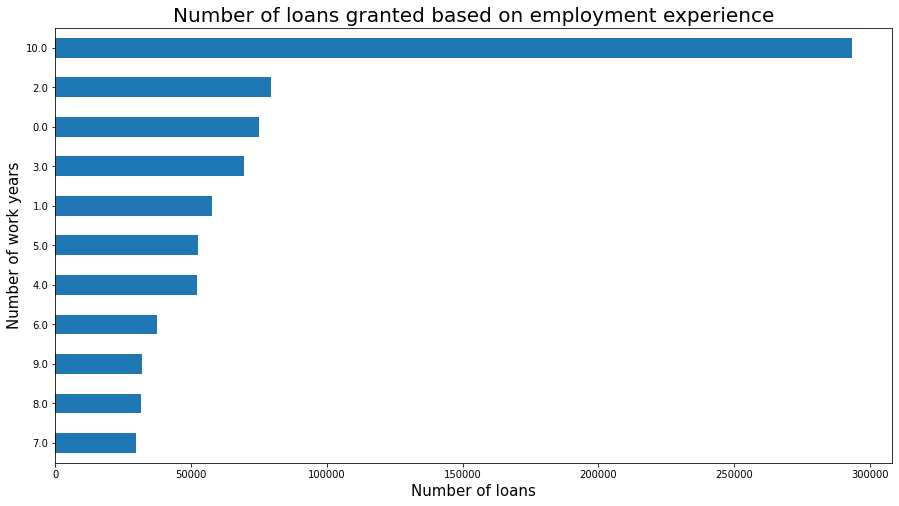

In [ ]:
df['emp_length'].value_counts().sort_values().plot(kind='barh',figsize=(15,8))
plt.title('Number of loans granted based on employment experience',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Number of work years',fontsize=15);

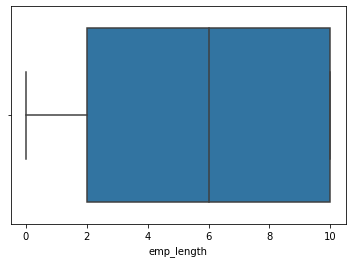

In [ ]:
# emp_length - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
sns.boxplot(df['emp_length'])
df['emp_length'].value_counts(dropna=False)
df['emp_length'].mean()
df['emp_length'].median()
df['emp_length'] =df['emp_length'].fillna(df['emp_length'].median())

In [ ]:
#home_ownership - correcting the values to valid ones
df['home_ownership'].value_counts(dropna=False)

MORTGAGE    424568
RENT        340989
OWN         104779
ANY            500
NONE             4
Name: home_ownership, dtype: int64

In [ ]:
df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [ ]:
df['home_ownership'].value_counts(dropna=False)

MORTGAGE    424568
RENT        340989
OWN         104779
OTHER          504
Name: home_ownership, dtype: int64

In [ ]:
df.info(max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870840 entries, 0 to 870839
Data columns (total 100 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     870840 non-null  float64
 1   term                            870840 non-null  object 
 2   int_rate                        870840 non-null  float64
 3   installment                     870840 non-null  float64
 4   grade                           870840 non-null  object 
 5   sub_grade                       870840 non-null  object 
 6   emp_title                       810003 non-null  object 
 7   emp_length                      870840 non-null  float64
 8   home_ownership                  870840 non-null  object 
 9   annual_inc                      870840 non-null  float64
 10  issue_d                         870840 non-null  object 
 11  loan_status                     870840 non-null  object 
 12  pymnt_plan     

In [ ]:
df['initial_list_status'].value_counts(dropna=False)

w    672010
f    198830
Name: initial_list_status, dtype: int64

In [ ]:
# correlation and heat map
#plt.figure(figsize=(30,20))
#sns.heatmap(df.corr(), cmap="YlGnBu")
#plt.show()

In [ ]:
df['application_type'].value_counts(dropna=False)

Individual    819833
Joint App      51007
Name: application_type, dtype: int64

In [ ]:
# removing those rows which are joint applications as we have removed related attributes for joint applications. 
# Focusing on individual applications in this analysis

ndf=df[df['application_type']=='Individual']
ndf['application_type'].value_counts(dropna=False)

Individual    819833
Name: application_type, dtype: int64

In [ ]:
ndf.shape

(819833, 100)

In [ ]:
# removing the application type column
ndf.drop(["application_type"], axis=1, inplace=True)

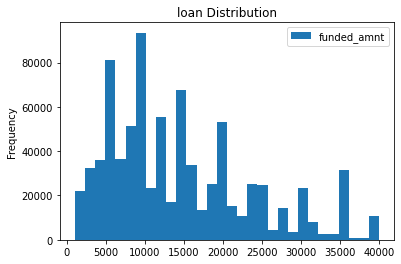

In [ ]:
ndf[['funded_amnt']].plot.hist(bins =30, title = 'loan Distribution')

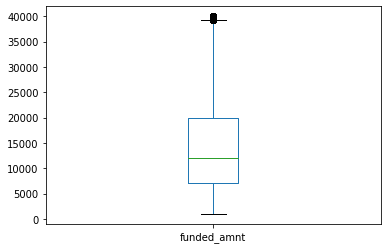

In [ ]:
ndf[['funded_amnt']].plot.box()

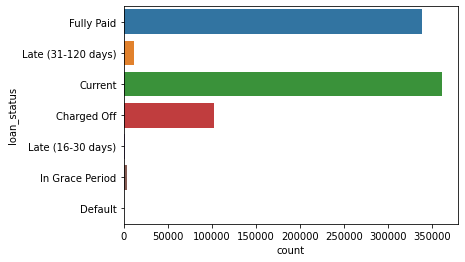

In [ ]:
 sns.countplot(y="loan_status", data=ndf)

In [ ]:
ndf['loan_status'].value_counts(dropna=False)

Current               361587
Fully Paid            338475
Charged Off           102001
Late (31-120 days)     11450
In Grace Period         4154
Late (16-30 days)       2140
Default                   26
Name: loan_status, dtype: int64

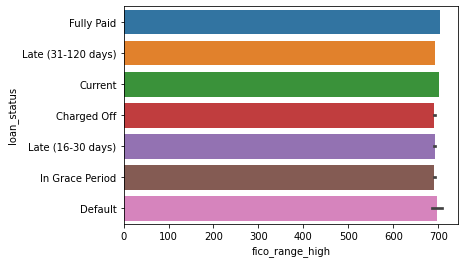

In [ ]:
sns.barplot(y="loan_status",x="fico_range_high",data=ndf)

In [ ]:
#plt.figure(figsize=(25, 15))
#plt.subplot(2,3,1)
#sns.barplot(y="loan_status",x="emp_length",data=ndf)
#plt.subplot(2,3,2)
#sns.barplot(y="loan_status",x="term",data=ndf)
#plt.subplot(2,3,3)
#sns.barplot(y="loan_status",x="int_rate",data=ndf)
#plt.subplot(2,3,4)
#sns.barplot(y="loan_status",x="fico_range_high",data=ndf)
#plt.subplot(2,3,5)
#sns.barplot(y="loan_status",x="dti",data=ndf)
#plt.subplot(2,3,6)
#sns.barplot(y="loan_status",x="fico_range_low",data=ndf)


In [ ]:
ndf.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                        2
grade                       7
sub_grade                  35
emp_title              191219
home_ownership              4
issue_d                    24
loan_status                 7
pymnt_plan                  2
purpose                    14
earliest_cr_line          702
initial_list_status         2
last_pymnt_d               39
next_pymnt_d                4
last_credit_pull_d         41
dtype: int64

In [ ]:
ndf['emp_title'].value_counts(dropna=False)
# almost emp_title              253709 - 2 Lakh unique values of emp_title values. We cannot encode such a long list of titles
# also, there is no much significant information with the column. Removing the column

ndf.drop(['emp_title'], axis=1, inplace=True)

In [ ]:
ndf["loan_status"].value_counts(dropna=False)

Current               361587
Fully Paid            338475
Charged Off           102001
Late (31-120 days)     11450
In Grace Period         4154
Late (16-30 days)       2140
Default                   26
Name: loan_status, dtype: int64

In [ ]:
def is_default(x):
    if x=='Default' or x=='Late (31-120 days)' or x=='Charged Off':
        return 1
    elif x=='Fully Paid':
        return 0
    elif x=='Current' or x=='Late (16-30 days)' or x=='In Grace Period':
        return -1

In [ ]:
ndf["is_default"] = ndf["loan_status"].apply(is_default)

In [ ]:
ndf["is_default"].value_counts(dropna=False)

-1    367881
 0    338475
 1    113477
Name: is_default, dtype: int64

In [ ]:
ndf.shape

(819833, 99)

In [ ]:
ndf.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                     2
grade                    7
sub_grade               35
home_ownership           4
issue_d                 24
loan_status              7
pymnt_plan               2
purpose                 14
earliest_cr_line       702
initial_list_status      2
last_pymnt_d            39
next_pymnt_d             4
last_credit_pull_d      41
dtype: int64

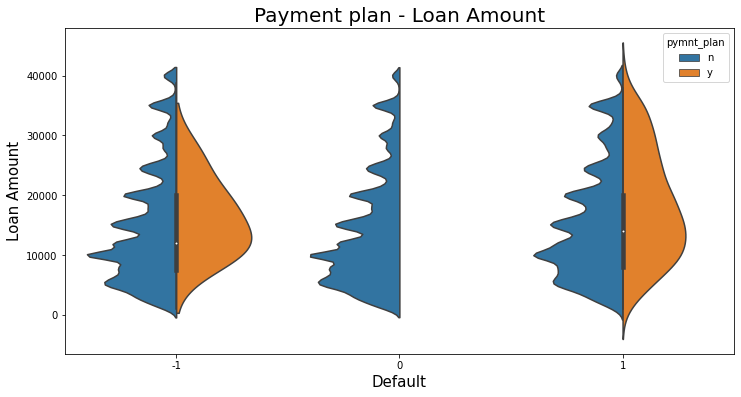

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="is_default",y="funded_amnt",data=ndf, hue="pymnt_plan", split=True)
plt.title("Payment plan - Loan Amount", fontsize=20)
plt.xlabel("Default", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

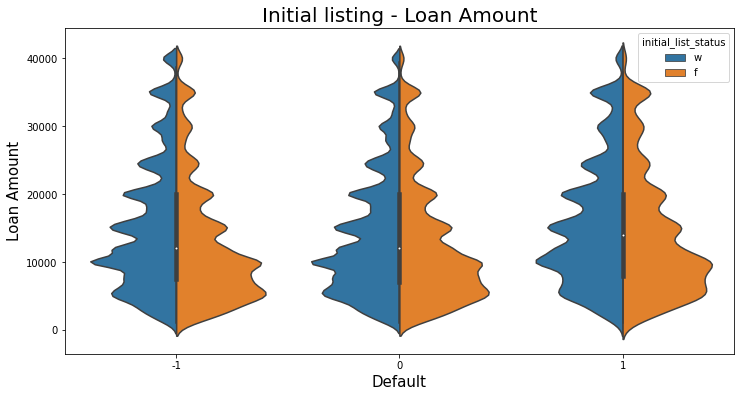

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="is_default",y="funded_amnt",data=ndf, hue="initial_list_status", split=True)
plt.title("Initial listing - Loan Amount", fontsize=20)
plt.xlabel("Default", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

In [ ]:
corr = ndf.corr()['is_default'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', corr.tail(10))
print('\nMost Negative Correlations:\n', corr.head(10))

Most Positive Correlations:
 open_il_24m                0.105550
open_il_12m                0.107992
inq_last_12m               0.109646
num_tl_op_past_12m         0.126814
acc_open_past_24mths       0.138520
int_rate                   0.154711
last_pymnt_amnt            0.223212
collection_recovery_fee    0.362525
recoveries                 0.367990
is_default                 1.000000
Name: is_default, dtype: float64

Most Negative Correlations:
 out_prncp               -0.520460
out_prncp_inv           -0.520416
last_fico_range_high    -0.448687
last_fico_range_low     -0.423250
total_rec_int           -0.158640
mo_sin_rcnt_tl          -0.085391
fico_range_low          -0.079413
fico_range_high         -0.079412
mo_sin_rcnt_rev_tl_op   -0.074998
mths_since_recent_inq   -0.066520
Name: is_default, dtype: float64


<h3> Handling Datetime attributes </h3>

In [ ]:
ndf['next_pymnt_d'].value_counts(dropna=False)

NaN         440476
Apr-2019    379169
Mar-2019       158
May-2019        29
Feb-2019         1
Name: next_pymnt_d, dtype: int64

In [ ]:
ndf['next_pymnt_d'] = pd.to_datetime(ndf['next_pymnt_d'],format='%b-%Y')
ndf['last_pymnt_d'] = pd.to_datetime(ndf['last_pymnt_d'],format='%b-%Y')

In [ ]:
# dervied variable - num_mths_for_next_pymnt
def num_mths_for_next_pymnt(x):
    if x["loan_status"]=='Fully Paid' or x["loan_status"]=='Charged Off':
        return 0
    else:
        return (x["next_pymnt_d"].year - x["last_pymnt_d"].year) * 12 + x["next_pymnt_d"].month - x["last_pymnt_d"].month

In [ ]:
ndf['num_mths_for_next_pymnt']=ndf.apply(num_mths_for_next_pymnt, axis=1)


In [ ]:
ndf['num_mths_for_next_pymnt'].value_counts(dropna=False)

0    440502
1    343995
2     26835
3      3658
4      2712
5      2118
6        12
9         1
Name: num_mths_for_next_pymnt, dtype: int64

In [ ]:
ndf['num_mths_for_next_pymnt'] =ndf['num_mths_for_next_pymnt'].fillna(0)

In [ ]:
# convert earliest_cr_line date form to months since credit line opened while comparing with issue_date

# dervied variable - num_mths_for_next_pymnt
def num_mths_since_cr_line_open(x):
        return (x["issue_d"].year - x["earliest_cr_line"].year) * 12 + x["issue_d"].month - x["earliest_cr_line"].month


In [ ]:
ndf['issue_d'] = pd.to_datetime(ndf['issue_d'],format='%b-%Y')
ndf['earliest_cr_line'] = pd.to_datetime(ndf['earliest_cr_line'],format='%b-%Y')
ndf['num_mths_since_cr_line_open']=ndf.apply(num_mths_since_cr_line_open, axis=1)

In [ ]:
ndf['num_mths_since_cr_line_open'].value_counts(dropna=False)

151    5136
143    5109
152    5063
146    5060
145    5057
       ... 
682       1
732       1
758       1
711       1
784       1
Name: num_mths_since_cr_line_open, Length: 708, dtype: int64

In [ ]:
ndf['earliest_cr_line'].value_counts(dropna=False)

2004-09-01    6215
2005-09-01    6204
2004-08-01    5969
2003-09-01    5943
2005-08-01    5916
              ... 
1958-07-01       1
1957-05-01       1
1949-06-01       1
1960-05-01       1
1948-01-01       1
Name: earliest_cr_line, Length: 702, dtype: int64

In [ ]:
ndf['issue_d'].value_counts(dropna=False)

2016-03-01    59943
2017-08-01    38543
2016-02-01    38448
2016-08-01    35930
2017-07-01    35726
2017-11-01    35712
2016-04-01    35510
2017-06-01    35137
2017-05-01    35135
2017-03-01    35051
2016-07-01    34439
2016-12-01    34338
2017-09-01    33563
2016-11-01    32752
2017-12-01    32597
2016-06-01    32578
2017-10-01    32296
2016-01-01    31635
2016-10-01    31460
2017-01-01    30205
2017-04-01    27528
2016-05-01    27496
2016-09-01    27465
2017-02-01    26346
Name: issue_d, dtype: int64

In [ ]:
ndf.drop(['earliest_cr_line'], axis=1, inplace=True)

In [ ]:
ndf.drop(['issue_d'], axis=1, inplace=True)

In [ ]:
ndf.drop(['last_credit_pull_d'], axis=1, inplace=True)

In [ ]:
ndf.drop(['last_pymnt_d'], axis=1, inplace=True)

In [ ]:
ndf.info(max_cols=170)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 819833 entries, 0 to 870839
Data columns (total 97 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   funded_amnt                     819833 non-null  float64       
 1   term                            819833 non-null  object        
 2   int_rate                        819833 non-null  float64       
 3   installment                     819833 non-null  float64       
 4   grade                           819833 non-null  object        
 5   sub_grade                       819833 non-null  object        
 6   emp_length                      819833 non-null  float64       
 7   home_ownership                  819833 non-null  object        
 8   annual_inc                      819833 non-null  float64       
 9   loan_status                     819833 non-null  object        
 10  pymnt_plan                      819833 non-null  object 

In [ ]:
ndf[ndf['num_mths_for_next_pymnt'].isnull()]

,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,is_default,num_mths_for_next_pymnt,num_mths_since_cr_line_open


In [ ]:
ndf.drop(['next_pymnt_d'], axis=1, inplace=True)

In [ ]:
# check for missing values once again
total_miss_data= ndf.isnull().sum().sort_values(ascending=False)
percent_miss_data= (ndf.isnull().sum()/ndf.isnull().count()).sort_values(ascending=False)*100
missing_data= pd.concat([total_miss_data, percent_miss_data],axis=1, keys=["Total", "Percent"])
missing_data

,Total,Percent
mths_since_last_record,670158,81.743233
mths_since_recent_bc_dlq,618537,75.446707
num_mths_since_cr_line_open,0,0.000000
initial_list_status,0,0.000000
out_prncp_inv,0,0.000000
total_pymnt,0,0.000000
total_pymnt_inv,0,0.000000
total_rec_prncp,0,0.000000
total_rec_int,0,0.000000
total_rec_late_fee,0,0.000000


In [ ]:
ndf.drop(['mths_since_last_record','mths_since_recent_bc_dlq'], axis=1, inplace=True)

In [ ]:
# removing charged off records from the dataset
#current_df=ndf[ndf['loan_status']=='Current']
#f_df=ndf[ndf['loan_status']!='Current']
f_df=ndf

In [ ]:
f_df['num_mths_since_cr_line_open'] = f_df['num_mths_since_cr_line_open'].astype(float)

In [ ]:
f_df.select_dtypes('float64').columns

Index(['funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',

<h3> Handling Categorical attributes </h3>

In [ ]:
f_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)


term                    2
grade                   7
sub_grade              35
home_ownership          4
loan_status             7
pymnt_plan              2
purpose                14
initial_list_status     2
dtype: int64

In [ ]:
f_df.dtypes.value_counts()

float64    84
object      8
int64       2
dtype: int64

In [ ]:
# label encoding - yes or no - 1 or 0
from sklearn import preprocessing

count = 0

for col in f_df:
    if f_df[col].dtype == 'object':
        if len(list(f_df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            f_df[col] = le.fit_transform(f_df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

term
pymnt_plan
initial_list_status
3 columns were label encoded.


In [ ]:
f_df['pymnt_plan'].value_counts()

0    819463
1       370
Name: pymnt_plan, dtype: int64

In [ ]:
f_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

grade              7
sub_grade         35
home_ownership     4
loan_status        7
purpose           14
dtype: int64

In [ ]:
f_df.drop(['loan_status'], axis=1, inplace=True)

In [ ]:
f_df = pd.get_dummies(f_df)
print(f_df.shape)

(819833, 149)


In [ ]:
f_df.info(max_cols=155)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 819833 entries, 0 to 870839
Data columns (total 149 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   funded_amnt                     819833 non-null  float64
 1   term                            819833 non-null  int64  
 2   int_rate                        819833 non-null  float64
 3   installment                     819833 non-null  float64
 4   emp_length                      819833 non-null  float64
 5   annual_inc                      819833 non-null  float64
 6   pymnt_plan                      819833 non-null  int64  
 7   dti                             819833 non-null  float64
 8   delinq_2yrs                     819833 non-null  float64
 9   fico_range_low                  819833 non-null  float64
 10  fico_range_high                 819833 non-null  float64
 11  inq_last_6mths                  819833 non-null  float64
 12  mths_since_last

In [ ]:
f_df['mths_since_recent_revol_delinq'].value_counts(dropna=False)

0.0      532226
13.0       5372
12.0       5339
15.0       5148
18.0       5106
14.0       5082
16.0       5082
9.0        5028
19.0       5023
6.0        4989
26.0       4958
7.0        4951
11.0       4908
22.0       4865
24.0       4846
25.0       4841
28.0       4836
21.0       4823
17.0       4818
8.0        4806
20.0       4799
10.0       4754
27.0       4654
23.0       4639
30.0       4630
29.0       4551
5.0        4489
31.0       4434
33.0       4407
32.0       4402
35.0       4337
34.0       4314
38.0       4229
37.0       4207
36.0       4204
39.0       4180
40.0       4037
41.0       4018
42.0       4010
43.0       4006
4.0        3988
44.0       3983
45.0       3885
47.0       3859
46.0       3795
48.0       3717
3.0        3473
49.0       3139
2.0        2656
74.0       2370
73.0       2322
72.0       2274
51.0       2235
1.0        2232
75.0       2228
69.0       2200
68.0       2198
50.0       2196
54.0       2191
76.0       2190
70.0       2185
71.0       2182
52.0    

In [ ]:
# correlation and heat map
#plt.figure(figsize=(30,20))
#sns.heatmap(f_df.corr(), cmap="YlGnBu")
#plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Sampling the data in random for 1 lakh records
samp_r = np.random.permutation(100000)
f_df_randomized = f_df.take(samp_r)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(f_df.drop('is_default',axis=1),f_df['is_default'],test_size=0.15,random_state=101)

In [ ]:
#X_train.info(max_cols=160)

In [ ]:
#X_train.head()

In [ ]:
#y_train.head()

In [ ]:
X=f_df_randomized.drop('is_default',axis=1)
y=f_df_randomized['is_default']

<h3> Standardising values </h3>

In [ ]:
# Standardising values:
from sklearn import preprocessing
sc = preprocessing.MinMaxScaler()
# Fit your data on the scaler object

var_col=f_df.select_dtypes('float64').columns

In [ ]:
print(var_col)

Index(['funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',

In [ ]:
X[var_col] = sc.fit_transform(X[var_col])
X.head()

#scaled_df = sc.fit_transform(sdf)
#scaled_df = pd.DataFrame(scaled_df, columns=s_columns)

,funded_amnt,term,int_rate,installment,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,num_mths_for_next_pymnt,num_mths_since_cr_line_open,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
92254,0.230769,0,0.100117,0.183718,1.0,0.006793,0,0.375100,0.190476,0.000000,0.000000,0.0,0.081481,0.1375,0.021277,0.012839,0.388356,0.111111,1,0.011659,0.011659,0.182940,0.182940,0.242233,0.049381,1.347400e-12,0.0,0.0,0.007585,0.798824,0.798817,0.0,0.0,0.0,0.037832,0.000000,0.051282,0.00,0.019608,0.057644,0.035460,0.306818,0.000000,0.037736,0.006092,0.362745,0.013567,0.0,0.045045,0.020408,0.053571,0.020255,0.014559,0.248950,0.000000,0.0,0.194864,0.075641,0.045662,0.069204,0.054054,0.048513,0.40,0.063218,0.000000,0.057143,0.117647,0.074074,0.071429,0.050314,0.116883,0.089109,0.127660,0.1375,0.0,0.0,0.00,0.00000,0.762,0.0,0.000,0.0,0.012720,0.041376,0.011851,0.040743,1,0.096674,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
41885,0.346154,1,0.211531,0.184114,0.1,0.004337,0,0.388511,0.000000,0.243243,0.241935,0.0,0.222222,0.1500,0.000000,0.013224,0.367882,0.116959,1,0.000000,0.000000,0.293771,0.293771,0.362500,0.121084,1.347400e-12,0.0,0.0,0.220024,0.863529,0.863905,0.0,0.0,0.0,0.014387,0.000000,0.179487,0.00,0.000000,0.102757,0.023529,0.287879,0.000000,0.037736,0.012340,0.333333,0.014733,0.0,0.018018,0.000000,0.035714,0.007703,0.016094,0.422915,0.000000,0.0,0.172205,0.111538,0.038813,0.058824,0.000000,0.026604,0.20,0.000000,0.000000,0.057143,0.058824,0.037037,0.042857,0.094340,0.077922,0.049505,0.063830,0.1500,0.0,0.0,0.00,0.00000,1.000,0.5,0.000,0.0,0.005458,0.031435,0.025974,0.028812,0,0.082121,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
941,0.128205,0,0.220880,0.108051,0.8,0.006271,0,0.411729,0.000000,0.027027,0.026882,0.2,0.577778,0.1750,0.021277,0.004836,0.131798,0.187135,0,0.000000,0.000000,0.113877,0.113877,0.150000,0.031980,1.347400e-

In [ ]:
# Apply PCA first - for dimensionality reduction
#Importing the PCA module

from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

#Doing the PCA on the train data
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [ ]:
pca.components_

array([[ 1.03581543e-01,  8.99789308e-02, -6.48320432e-02, ...,
        -3.21875490e-03, -4.63777426e-03,  0.00000000e+00],
       [ 5.84358916e-02,  2.34047093e-01,  6.05453498e-02, ...,
        -7.21897844e-04, -2.02041887e-03, -0.00000000e+00],
       [-7.28786871e-02, -1.85719936e-01, -1.61783429e-01, ...,
         2.49406359e-03,  4.20277142e-03, -0.00000000e+00],
       ...,
       [-0.00000000e+00, -8.49690180e-20,  6.46685600e-19, ...,
        -8.45905492e-06, -8.45905492e-06, -0.00000000e+00],
       [ 0.00000000e+00,  2.71822837e-20,  3.70323212e-19, ...,
        -7.03999671e-18, -7.07174857e-18,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,0.103582,0.058436,funded_amnt
1,0.089979,0.234047,term
2,-0.064832,0.060545,int_rate
3,0.063567,0.022906,installment
4,0.140518,0.022246,emp_length


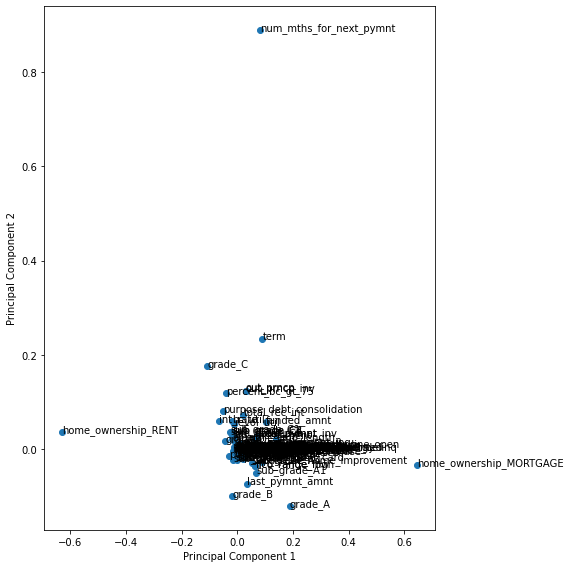

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([1.02019506e-01, 8.48700988e-02, 8.31166530e-02, 7.19564190e-02,
       6.48904318e-02, 4.94372081e-02, 4.51863119e-02, 3.75827484e-02,
       3.49563937e-02, 3.30155651e-02, 2.60898016e-02, 2.57397164e-02,
       2.26345987e-02, 1.79451385e-02, 1.53579329e-02, 1.41632819e-02,
       1.37895049e-02, 1.36927381e-02, 1.32839581e-02, 1.24725393e-02,
       1.22145772e-02, 1.17207704e-02, 1.14182251e-02, 1.11969914e-02,
       1.04004080e-02, 1.02110721e-02, 9.22799446e-03, 8.34487450e-03,
       7.21593753e-03, 6.98062163e-03, 6.67941817e-03, 6.47742223e-03,
       6.09310895e-03, 5.34513496e-03, 5.20936519e-03, 5.07135672e-03,
       4.76602006e-03, 4.67435679e-03, 4.36485520e-03, 4.14767704e-03,
       4.07527008e-03, 3.83711844e-03, 3.40305214e-03, 3.21668676e-03,
       3.11139869e-03, 2.82698292e-03, 2.66979781e-03, 2.50252859e-03,
       2.42797737e-03, 2.24101662e-03, 2.17843740e-03, 2.07795548e-03,
       2.04661785e-03, 1.93226275e-03, 1.75549201e-03, 1.73577734e-03,
      

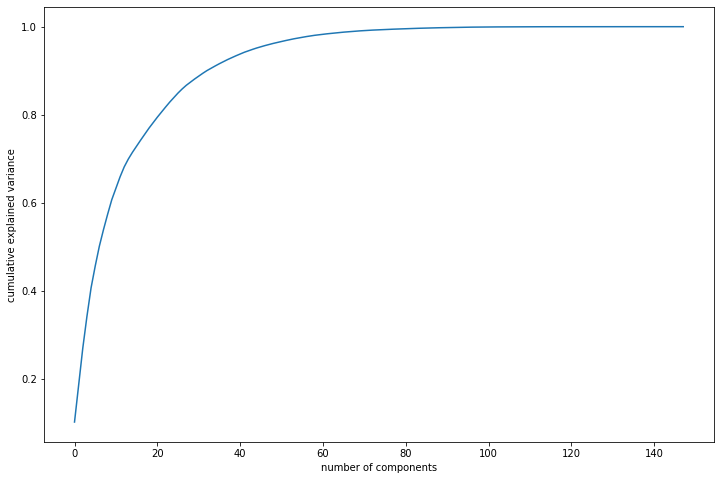

In [ ]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=40)

X_pca = pca_final.fit_transform(X)
X_pca.shape

(100000, 40)

In [ ]:
corrmat = np.corrcoef(X_pca.transpose())

In [ ]:
#%matplotlib inline
#plt.figure(figsize = (20,10))
#sns.heatmap(corrmat,annot = True)

In [ ]:
def print_metrics(y_train, y_test, y_train_pred, y_test_pred, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, y_train_pred)))
        print("Classification Report: \n {}\n".format(classification_report(y_train, y_train_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, y_train_pred)))
        #res = cross_val_score(samp_model, X_train, y_train, cv=10, scoring='accuracy')
        #print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        #print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_test_pred)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, y_test_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_test_pred)))
        print('ROC-AUC score:',roc_auc_score(y_test, y_test_pred))

<h3>Label propagation - Labelling unlabelled data</h3>

Label spreading using KNN - default values. 

In [ ]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

In [ ]:
X_l = X_pca
y_l = y
X_l.shape

(100000, 40)

In [ ]:
y_l.shape

(100000,)

In [ ]:
# Learn with LabelSpreading with default values
label_spread_knn = LabelSpreading(kernel='knn',n_neighbors=1)

In [ ]:
label_spread_knn.fit(X_l, y_l)

LabelSpreading(alpha=0.2, gamma=20, kernel='knn', max_iter=30, n_jobs=None,
               n_neighbors=1, tol=0.001)

In [ ]:
#y_reject_proba = label_spread.predict_proba(X_l_sam)
y_predict_spread_knn = label_spread_knn.predict(X_l)

In [ ]:
label_spread_knn.transduction_.shape

(100000,)

In [ ]:
predicted_labels_spread_knn = label_spread_knn.transduction_

In [ ]:
true_labels=y_l

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels_spread_knn, labels=label_spread_knn.classes_)
print(classification_report(true_labels, predicted_labels_spread_knn))
#print('ROC-AUC score:',roc_auc_score(true_labels, predicted_labels_spread_knn))
print("Confusion matrix")
print(cm)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     34399
           0       0.58      1.00      0.74     48271
           1       1.00      1.00      1.00     17330

    accuracy                           0.66    100000
   macro avg       0.53      0.67      0.58    100000
weighted avg       0.46      0.66      0.53    100000

Confusion matrix
[[48271     0]
 [    0 17330]]


In [ ]:
y_predict_spread_knn_df=pd.DataFrame(y_predict_spread_knn)
y_predict_spread_knn_df.value_counts()

0    82670
1    17330
dtype: int64

<h3>Label spreading using 'KNN' - with fine tuned hyper parameters gamma and alpha</h3>

In [ ]:
# Sampling the data in random
samp_r = np.random.permutation(100000)
f_df_randomized = f_df.take(samp_r)
X_train_sam, X_test_sam, y_train_sam, y_test_sam = train_test_split(f_df_randomized.drop('is_default',axis=1),f_df_randomized['is_default'],test_size=0.15,random_state=101)

In [ ]:
# GridSearchCV to find optimal alpha - label propagation
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'alpha': [0.2,0.4,0.6,0.8] }

# instantiate the model
label_spread = LabelSpreading(kernel='knn', n_neighbors=2)

In [ ]:
# fit tree on training data
l_spread = GridSearchCV(label_spread, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)

In [ ]:
l_spread.fit(X_train_sam, y_train_sam)

In [ ]:
# scores of GridSearch CV
scores = l_spread.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with alpha
plt.figure()
plt.plot(scores["param_alpha"], 
         scores["mean_train_score"],
         label="training precision")
plt.plot(scores["param_alpha"], 
         scores["mean_test_score"], 
         label="test precision")
plt.xlabel("alpha")
plt.ylabel("precision")
plt.legend()
plt.show()

In [ ]:
import gc
gc.collect()

In [ ]:
# for gamma - find the right parameter range
# GridSearchCV to find optimal alpha - label propagation
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_neighbors': range(1, 5, 1)}

# instantiate the model
label_spread = LabelSpreading(kernel='knn')


# fit tree on training data
l_spread = GridSearchCV(label_spread, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)

In [ ]:
l_spread.fit(X_train_sam, y_train_sam)

In [ ]:
# scores of GridSearch CV
scores = l_spread.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_n_neighbors"], 
         scores["mean_train_score"], 
         label="training precision")
plt.plot(scores["param_n_neighbors"], 
         scores["mean_test_score"], 
         label="test precision")
plt.xlabel("n_neighbors")
plt.ylabel("precision")
plt.legend()
plt.show()

In [ ]:
# for gamma - find the right parameter range
# GridSearchCV to find optimal alpha - label propagation
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'gamma': range(10, 50, 10)}

# instantiate the model
label_spread = LabelSpreading(kernel='knn')


# fit tree on training data
l_spread = GridSearchCV(label_spread, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)


In [ ]:
l_spread.fit(X_train_sam, y_train_sam)

In [ ]:
# scores of GridSearch CV
scores = l_spread.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_gamma"], 
         scores["mean_train_score"], 
         label="training precision")
plt.plot(scores["param_gamma"], 
         scores["mean_test_score"], 
         label="test precision")
plt.xlabel("gamma")
plt.ylabel("precision")
plt.legend()
plt.show()

In [ ]:
label_spread = LabelSpreading(kernel='knn',alpha=0.2,n_neighbors=1,gamma=10)

In [ ]:
# Fit the grid search to the data
label_spread.fit(X_l, y_l)

In [ ]:
y_predicted_labels_spread = label_spread.transduction_
true_labels=y_l
cm = confusion_matrix(y_true_labels, y_predicted_labels_spread, labels=(0,1))
print(classification_report(y_true_labels, y_predicted_labels_spread,labels=(0,1)))
print('ROC-AUC score:',roc_auc_score(y_true_labels, y_predicted_labels_spread))
print("Confusion matrix")
print(cm)

In [ ]:
# plotting accuracies with min_samples_leaf
#plt.figure()
#plt.plot(scores["param_gamma"], 
#         scores["mean_train_score"], 
#         label="training precision")
#plt.plot(scores["param_gamma"], 
#         scores["mean_test_score"], 
#         label="test precision")
#plt.xlabel("gamma")
#plt.ylabel("precision")
#plt.legend()
#plt.show()

<h3> Label propagation - KNN </h3>

In [ ]:
# Label propagation
# Assigning data frames
#X_l = df_train_pca
#y_l = y_train


In [ ]:
# Learn with LabelSpreading with default values - default being SVM
label_prop = LabelPropagation(kernel='knn', n_neighbors=1)

In [ ]:
label_prop.fit(X_l, y_l)

LabelPropagation(gamma=20, kernel='knn', max_iter=1000, n_jobs=None,
                 n_neighbors=1, tol=0.001)

In [ ]:
y_prop_predicted_labels=label_prop.predict(X_l)

In [ ]:
label_prop.transduction_.shape

(100000,)

In [ ]:
predicted_labels_prop = label_prop.transduction_
true_labels=y_l
cm = confusion_matrix(true_labels, predicted_labels_prop, labels=[0,1])
print(classification_report(true_labels, predicted_labels_prop))
#print('ROC-AUC score:',roc_auc_score(true_labels, predicted_labels_prop))
print("Confusion matrix")
print(cm)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     34399
           0       0.58      1.00      0.74     48271
           1       1.00      1.00      1.00     17330

    accuracy                           0.66    100000
   macro avg       0.53      0.67      0.58    100000
weighted avg       0.46      0.66      0.53    100000

Confusion matrix
[[48271     0]
 [    0 17330]]


In [ ]:
predicted_labels_prop

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_prop_predicted=pd.DataFrame(predicted_labels_prop)

In [ ]:
y_prop_predicted.value_counts()

0    82670
1    17330
dtype: int64

# <h3>Using Label spreading - Without explicit Class imbalance handling</h3>

In [ ]:
#Splitting into train test split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X,y_predict_spread_knn,test_size=0.15,random_state=101)

Label propagation with KNN


<h3> Logistic regression - Label spreading </h3>




In [ ]:
lr = LogisticRegression(class_weight='balanced')
model_lr_prop = lr.fit(X_train_s,y_train_s)

In [ ]:
# Traning metrics
y_train_lr_pred = model_lr_prop.predict(X_train_s)
y_test_lr_pred = model_lr_prop.predict(X_test_s))
print_metrics(y_train_s, y_test_s, y_train_lr_pred, y_test_lr_pred,train=True)

Train Result:

accuracy score: 0.9854

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    600468
           1       0.93      0.97      0.95     96390

    accuracy                           0.99    696858
   macro avg       0.96      0.98      0.97    696858
weighted avg       0.99      0.99      0.99    696858


Confusion Matrix: 
 [[592979   7489]
 [  2719  93671]]



In [ ]:
print_metrics(y_train_s, y_test_s,y_train_lr_pred, y_test_lr_pred,train=False)

Test Result:

accuracy score: 0.9861

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    105888
           1       0.93      0.97      0.95     17087

    accuracy                           0.99    122975
   macro avg       0.96      0.98      0.97    122975
weighted avg       0.99      0.99      0.99    122975


Confusion Matrix: 
 [[104613   1275]
 [   438  16649]]

ROC-AUC score: 0.981162726480147


<h3> Random Forest - Label propagation - without class imbalancing </h3>



In [ ]:
rfc_l_prop_wo_ci = RandomForestClassifier()

In [ ]:
rfc_l_prop_wo_ci.fit(X_train_s,y_train_s)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Traning metrics
y_train_rfc_pred = rfc_l_prop_wo_ci.predict(X_train_s)
y_test_rfc_pred = rfc_l_prop_wo_ci.predict(X_test_s)
print_metrics(y_train_s, y_test_s,y_train_rfc_pred,y_test_rfc_pred,train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    600468
           1       1.00      1.00      1.00     96390

    accuracy                           1.00    696858
   macro avg       1.00      1.00      1.00    696858
weighted avg       1.00      1.00      1.00    696858


Confusion Matrix: 
 [[600468      0]
 [     0  96390]]



In [ ]:
print_metrics(y_train_s, y_test_s,y_train_rfc_pred,y_test_rfc_pred,train=False)

Test Result:

accuracy score: 0.9950

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    105888
           1       1.00      0.97      0.98     17087

    accuracy                           1.00    122975
   macro avg       1.00      0.98      0.99    122975
weighted avg       1.00      1.00      0.99    122975


Confusion Matrix: 
 [[105845     43]
 [   569  16518]]

ROC-AUC score: 0.9831468704136616


Label propagation with KNN

In [ ]:
#Splitting into train test split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X,y_prop_predicted_labels,test_size=0.15,random_state=101)

Logistic Regression

In [ ]:
lr = LogisticRegression(class_weight='balanced')
model_lr_p = lr.fit(X_train_p,y_train_p)

In [ ]:
#pred_probs_test = model_lr_s.predict_proba(df_test_pca)
#"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

In [ ]:
# Traning metrics
y_train_lr_p_pred = model_lr_p.predict(X_train_p)
y_test_lr_p_pred = model_lr_p.predict(X_test_p)
print_metrics(y_train_p, y_test_p,y_train_lr_p_pred,y_test_lr_p_pred,train=True)

Train Result:

accuracy score: 0.9854

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    600468
           1       0.93      0.97      0.95     96390

    accuracy                           0.99    696858
   macro avg       0.96      0.98      0.97    696858
weighted avg       0.99      0.99      0.99    696858


Confusion Matrix: 
 [[592979   7489]
 [  2719  93671]]



In [ ]:
print_metrics(y_train_p, y_test_p,y_train_lr_p_pred,y_test_lr_p_pred,train=False)

Test Result:

accuracy score: 0.9861

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    105888
           1       0.93      0.97      0.95     17087

    accuracy                           0.99    122975
   macro avg       0.96      0.98      0.97    122975
weighted avg       0.99      0.99      0.99    122975


Confusion Matrix: 
 [[104613   1275]
 [   438  16649]]

ROC-AUC score: 0.981162726480147


<h3> Random forests - label propagation - without explicit class imbalance </h3>

In [ ]:
#Random forests without handling class imbalance
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc_ls_wo_ci = RandomForestClassifier()

In [ ]:
rfc_ls_wo_ci.fit(X_train_p,y_train_p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Traning metrics
y_train_rfc_p_pred = rfc_ls_wo_ci.predict(X_train_p)
y_test_rfc_p_pred = rfc_ls_wo_ci.predict(X_test_p)
print_metrics(y_train_p, y_test_p,y_train_rfc_p_pred,y_test_rfc_p_pred,train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    600468
           1       1.00      1.00      1.00     96390

    accuracy                           1.00    696858
   macro avg       1.00      1.00      1.00    696858
weighted avg       1.00      1.00      1.00    696858


Confusion Matrix: 
 [[600468      0]
 [     0  96390]]



In [ ]:
print_metrics(y_train_p, y_test_p,y_train_rfc_p_pred,y_test_rfc_p_pred,train=False)

Test Result:

accuracy score: 0.9952

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    105888
           1       1.00      0.97      0.98     17087

    accuracy                           1.00    122975
   macro avg       1.00      0.98      0.99    122975
weighted avg       1.00      1.00      1.00    122975


Confusion Matrix: 
 [[105863     25]
 [   568  16519]]

ROC-AUC score: 0.983261127892626


In [ ]:
import gc
gc.collect()

385

<h3> Handling Class imbalancing - with SMOTE Oversampling</h3>

Label spreading

In [ ]:
# Oversampling with SMOTE - handling class imbalancing
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)


In [ ]:
X_train_s_os, y_train_s_os = sm.fit_resample(X_train_s, y_train_s)

In [ ]:
pd.DataFrame(y_train_s_os).value_counts()

1    600468
0    600468
dtype: int64

<h3>Building Logistic regression - label spreading</h3>

In [ ]:
lr = LogisticRegression()
lr_model_sm = lr.fit(X_train_s_os, y_train_s_os)

In [ ]:
# Traning metrics
y_train_lr_sm_s_pred = lr_model_sm.predict(X_train_s_os)
y_test_lr_sm_s_pred = lr_model_sm.predict(X_test_s)
print_metrics(y_train_s_os, y_test_s,y_train_lr_sm_s_pred,y_test_lr_sm_s_pred,train=True)


Train Result:

accuracy score: 0.9862

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99    600468
           1       0.99      0.98      0.99    600468

    accuracy                           0.99   1200936
   macro avg       0.99      0.99      0.99   1200936
weighted avg       0.99      0.99      0.99   1200936


Confusion Matrix: 
 [[594839   5629]
 [ 10953 589515]]



In [ ]:
print_metrics(y_train_s_os, y_test_s,y_train_lr_sm_s_pred,y_test_lr_sm_s_pred,train=False)

Test Result:

accuracy score: 0.9883

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    105888
           1       0.95      0.97      0.96     17087

    accuracy                           0.99    122975
   macro avg       0.97      0.98      0.98    122975
weighted avg       0.99      0.99      0.99    122975


Confusion Matrix: 
 [[104938    950]
 [   491  16596]]

ROC-AUC score: 0.9811464802159173


<h3>Building model - Random forest - Label spreading </h3>

In [ ]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc_ls = RandomForestClassifier()

In [ ]:
# fit
rfc_ls.fit(X_train_s_os, y_train_s_os)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_train_rfc_ls_pred = rfc_ls.predict(X_train_s_os)
y_test_rfc_ls_pred = rfc_ls.predict(X_test_s)
print_metrics(y_train_s_os, y_test_s,y_train_rfc_ls_pred,y_test_rfc_ls_pred,train=True)


Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    600468
           1       1.00      1.00      1.00    600468

    accuracy                           1.00   1200936
   macro avg       1.00      1.00      1.00   1200936
weighted avg       1.00      1.00      1.00   1200936


Confusion Matrix: 
 [[600468      0]
 [     0 600468]]



In [ ]:
print_metrics(y_train_s_os, y_test_s,y_train_rfc_ls_pred,y_test_rfc_ls_pred,train=False)

Test Result:

accuracy score: 0.9948

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    105888
           1       1.00      0.97      0.98     17087

    accuracy                           0.99    122975
   macro avg       1.00      0.98      0.99    122975
weighted avg       0.99      0.99      0.99    122975


Confusion Matrix: 
 [[105815     73]
 [   564  16523]]

ROC-AUC score: 0.9831515213624272


<h3> Building Model - Logistic Regression - label propagation </h3>

In [ ]:
X_train_p_os, y_train_p_os = sm.fit_resample(X_train_p, y_train_p)

In [ ]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression()
lr_model = lr.fit(X_train_p_os, y_train_p_os)

In [ ]:
# Training Metrics - 
y_train_lr_lp_pred = lr_model.predict(X_train_p_os)
y_test_lr_lp_pred = lr_model.predict(X_test_p)
print_metrics(y_train_p_os, y_test_p,y_train_lr_lp_pred,y_test_lr_lp_pred,train=True)

Train Result:

accuracy score: 0.9892

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     70211
           1       0.99      0.99      0.99     70211

    accuracy                           0.99    140422
   macro avg       0.99      0.99      0.99    140422
weighted avg       0.99      0.99      0.99    140422


Confusion Matrix: 
 [[69684   527]
 [  989 69222]]



In [ ]:
# Testing Metrics - 
print_metrics(y_train_p_os, y_test_p,y_train_lr_lp_pred,y_test_lr_lp_pred,train=False)

Test Result:

accuracy score: 0.9891

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     12459
           1       0.96      0.97      0.97      2541

    accuracy                           0.99     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.99      0.99      0.99     15000


Confusion Matrix: 
 [[12368    91]
 [   72  2469]]

ROC-AUC score: 0.9821803709792678


<h3> Model - Random forests classifier - with default hyper parameters </h3>

In [ ]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [ ]:
# fit
rfc.fit(X_train_p_os, y_train_p_os)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Training Metrics - 
y_train_rfc_lp_pred = rfc.predict(X_train_p_os)
y_test_rfc_lp_pred = rfc.predict(X_test_p)
print_metrics(y_train_p_os, y_test_p,y_train_rfc_lp_pred,y_test_rfc_lp_pred,train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     70211
           1       1.00      1.00      1.00     70211

    accuracy                           1.00    140422
   macro avg       1.00      1.00      1.00    140422
weighted avg       1.00      1.00      1.00    140422


Confusion Matrix: 
 [[70211     0]
 [    0 70211]]



In [ ]:
print_metrics(y_train_p_os, y_test_p,y_train_rfc_lp_pred,y_test_rfc_lp_pred,train=False)

Test Result:

accuracy score: 0.9940

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     12459
           1       0.99      0.97      0.98      2541

    accuracy                           0.99     15000
   macro avg       0.99      0.98      0.99     15000
weighted avg       0.99      0.99      0.99     15000


Confusion Matrix: 
 [[12445    14]
 [   76  2465]]

ROC-AUC score: 0.9844834149280004


<h3> Handling with undersampling - Tomek Links - Label spreading </h3>

In [ ]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority')


In [ ]:
X_train_s_tl, y_train_s_tl = tl.fit_resample(X_train_s, y_train_s)

<h3> Building logistic regression with undersampling - Tomek Links</h3>

In [ ]:
#Training the model on the train data
lr_tl = LogisticRegression()
lr_tl_model = lr_tl.fit(X_train_s_tl, y_train_s_tl)

In [ ]:
y_train_pred_lr_tl = lr_tl_model.predict(X_train_s_tl)
y_test_pred_lr_tl = lr_tl_model.predict(X_test_s)
print_metrics(y_train_s_tl, y_test_s, y_train_pred_lr_tl, y_test_pred_lr_tl, train=True)

Train Result:

accuracy score: 0.9882

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     68614
           1       0.99      0.94      0.97     14767

    accuracy                           0.99     83381
   macro avg       0.99      0.97      0.98     83381
weighted avg       0.99      0.99      0.99     83381


Confusion Matrix: 
 [[68483   131]
 [  855 13912]]



In [ ]:
print_metrics(y_train_s_tl, y_test_s, y_train_pred_lr_tl, y_test_pred_lr_tl, train=False)

Test Result:

accuracy score: 0.9890

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     12437
           1       0.99      0.95      0.97      2563

    accuracy                           0.99     15000
   macro avg       0.99      0.97      0.98     15000
weighted avg       0.99      0.99      0.99     15000


Confusion Matrix: 
 [[12406    31]
 [  134  2429]]

ROC-AUC score: 0.9726124780089466


<h3> Building Random forest model with undersampling - Tomek Links <h3>

In [ ]:
# default model
rfc_tl = RandomForestClassifier()
rfc_tl_model=rfc_tl.fit(X_train_s_tl, y_train_s_tl)

In [ ]:
y_train_pred_rfc_tl = rfc_tl_model.predict(X_train_s_tl)
y_test_pred_rfc_tl = rfc_tl_model.predict(X_test_s)
print_metrics(y_train_s_tl, y_test_s, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     68614
           1       1.00      1.00      1.00     14767

    accuracy                           1.00     83381
   macro avg       1.00      1.00      1.00     83381
weighted avg       1.00      1.00      1.00     83381


Confusion Matrix: 
 [[68614     0]
 [    0 14767]]



In [ ]:
print_metrics(y_train_s_tl, y_test_s, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=False)

Test Result:

accuracy score: 0.9941

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     12437
           1       1.00      0.97      0.98      2563

    accuracy                           0.99     15000
   macro avg       0.99      0.98      0.99     15000
weighted avg       0.99      0.99      0.99     15000


Confusion Matrix: 
 [[12425    12]
 [   77  2486]]

ROC-AUC score: 0.9844961093180012


<h3> Undersampling - Tomek Links - Label Propagation </h3>

In [ ]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority')
X_train_p_tl, y_train_p_tl = tl.fit_resample(X_train_p, y_train_p)

NameError: ignored

In [ ]:
#Training the model on the train data
lr_tl = LogisticRegression()
lr_tl_model = lr_tl.fit(X_train_p_tl, y_train_p_tl)

AttributeError: ignored

In [ ]:
y_train_pred_lr_tl = lr_tl_model.predict(X_train_p_tl)
y_test_pred_lr_tl = lr_tl_model.predict(X_test_p)
print_metrics(y_train_p_tl, y_test_p, y_train_pred_lr_tl, y_test_pred_lr_tl, train=True)

In [ ]:
print_metrics(y_train_p_tl, y_test_p, y_train_pred_lr_tl, y_test_pred_lr_tl, train=False)

Random forests with Label propagation

In [ ]:
# default model
rfc_tl = RandomForestClassifier()
rfc_tl_model=rfc_tl.fit(X_train_p_tl, y_train_p_tl)

In [ ]:
y_train_pred_rfc_tl = rfc_tl_model.predict(X_train_p_tl)
y_test_pred_rfc_tl = rfc_tl_model.predict(X_test_p)
print_metrics(y_train_p_tl, y_test_p, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=True)

In [ ]:
print_metrics(y_train_p_tl, y_test_p, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=False)

<h3> Handling class imbalancing with Near Miss undersampling technique </h3>

In [ ]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(sampling_strategy='majority')
X_train_s_nm, y_train_s_nm = nm.fit_resample(X_train_s, y_train_s)

<h3> Building Logistic regression with Near Miss undersampling - Label spreading <h3>

In [ ]:
#Training the model on the train data
lr_tl = LogisticRegression()
lr_tl_model = lr_tl.fit(X_train_s_nm, y_train_s_nm)

In [ ]:
y_train_pred_lr_tl = lr_tl_model.predict(X_train_s_nm)
y_test_pred_lr_tl = lr_tl_model.predict(X_test_s)
print_metrics(y_train_s_nm, y_test_s, y_train_pred_lr_tl, y_test_pred_lr_tl, train=True)

Train Result:

accuracy score: 0.9929

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     14767
           1       0.99      0.99      0.99     14767

    accuracy                           0.99     29534
   macro avg       0.99      0.99      0.99     29534
weighted avg       0.99      0.99      0.99     29534


Confusion Matrix: 
 [[14690    77]
 [  133 14634]]



In [ ]:
print_metrics(y_train_s_nm, y_test_s, y_train_pred_lr_tl, y_test_pred_lr_tl, train=False)

Test Result:

accuracy score: 0.7373

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.68      0.81     12437
           1       0.39      0.99      0.56      2563

    accuracy                           0.74     15000
   macro avg       0.70      0.84      0.69     15000
weighted avg       0.89      0.74      0.77     15000


Confusion Matrix: 
 [[8517 3920]
 [  21 2542]]

ROC-AUC score: 0.8383089632457692


<h3> Building Random Forest model with Near Miss undersampling - Label spreading </h3>

In [ ]:
# default model
rfc_tl = RandomForestClassifier()
rfc_tl_model=rfc_tl.fit(X_train_s_nm, y_train_s_nm)

In [ ]:
y_train_pred_rfc_tl = rfc_tl_model.predict(X_train_s_nm)
y_test_pred_rfc_tl = rfc_tl_model.predict(X_test_s)
print_metrics(y_train_s_nm, y_test_s, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14767
           1       1.00      1.00      1.00     14767

    accuracy                           1.00     29534
   macro avg       1.00      1.00      1.00     29534
weighted avg       1.00      1.00      1.00     29534


Confusion Matrix: 
 [[14767     0]
 [    0 14767]]



In [ ]:
print_metrics(y_train_s_nm, y_test_s, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=False)

Test Result:

accuracy score: 0.6689

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.60      0.75     12437
           1       0.34      0.99      0.51      2563

    accuracy                           0.67     15000
   macro avg       0.67      0.80      0.63     15000
weighted avg       0.89      0.67      0.71     15000


Confusion Matrix: 
 [[7489 4948]
 [  18 2545]]

ROC-AUC score: 0.7975659202991741


<h3>Near miss undersampling with label propagation <h3>

In [ ]:
X_train_p_nm, y_train_p_nm = nm.fit_resample(X_train_p, y_train_p)

Logistic Regression

In [ ]:
#Training the model on the train data
lr_tl = LogisticRegression()
lr_tl_model = lr_tl.fit(X_train_p_nm, y_train_p_nm)

In [ ]:
y_train_pred_lr_tl = lr_tl_model.predict(X_train_p_nm)
y_test_pred_lr_tl = lr_tl_model.predict(X_test_p)
print_metrics(y_train_p_nm, y_test_p, y_train_pred_lr_tl, y_test_pred_lr_tl, train=True)

Train Result:

accuracy score: 0.9929

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     14767
           1       0.99      0.99      0.99     14767

    accuracy                           0.99     29534
   macro avg       0.99      0.99      0.99     29534
weighted avg       0.99      0.99      0.99     29534


Confusion Matrix: 
 [[14690    77]
 [  133 14634]]



In [ ]:
print_metrics(y_train_p_nm, y_test_p, y_train_pred_lr_tl, y_test_pred_lr_tl, train=False)

Test Result:

accuracy score: 0.7373

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.68      0.81     12437
           1       0.39      0.99      0.56      2563

    accuracy                           0.74     15000
   macro avg       0.70      0.84      0.69     15000
weighted avg       0.89      0.74      0.77     15000


Confusion Matrix: 
 [[8517 3920]
 [  21 2542]]

ROC-AUC score: 0.8383089632457692


Random forests

In [ ]:
# default model
rfc_tl = RandomForestClassifier()
rfc_tl_model=rfc_tl.fit(X_train_p_nm, y_train_p_nm)

In [ ]:
y_train_pred_rfc_tl = rfc_tl_model.predict(X_train_p_nm)
y_test_pred_rfc_tl = rfc_tl_model.predict(X_test_p)
print_metrics(y_train_p_nm, y_test_p, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14767
           1       1.00      1.00      1.00     14767

    accuracy                           1.00     29534
   macro avg       1.00      1.00      1.00     29534
weighted avg       1.00      1.00      1.00     29534


Confusion Matrix: 
 [[14767     0]
 [    0 14767]]



In [ ]:
print_metrics(y_train_p_nm, y_test_p, y_train_pred_rfc_tl, y_test_pred_rfc_tl, train=False)

Test Result:

accuracy score: 0.6825

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.62      0.76     12437
           1       0.35      0.99      0.52      2563

    accuracy                           0.68     15000
   macro avg       0.67      0.81      0.64     15000
weighted avg       0.89      0.68      0.72     15000


Confusion Matrix: 
 [[7691 4746]
 [  17 2546]]

ROC-AUC score: 0.8058819336698473


Steps further - 
1. To include various class imbalancing techniques and try identify various results
2. To include rejected loan applications and perform reject inference 


In [ ]:
# run gc.collect() (garbage collect) to free up memory
# else, since the dataset is large and SVM is computationally heavy,
# it'll throw a memory error while training
import gc
gc.collect()